# Numpyro modelling of psychometric functions

Thomas Wallis

In [1]:
import pandas as pd

import plotnine as pn

import pickle
import lzma 

import numpy as np
import arviz as az
import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax import random

from itertools import product

import numpyro
from numpyro.diagnostics import hpdi

from src.helpers import get_top_directory, preprocess_data 
from src.numpyro_models import PsychometricFunctionWrapper, SinglePsychometricFunction, ParticipantsAllConditions, ParticipantsAllConditionsAndImages, expand_grid, group_bernoulli_trials_into_binomial, plot_psychometric_function

numpyro.set_platform("cpu")
numpyro.set_host_device_count(4)

%load_ext autoreload
%autoreload 2

/Users/tsawallis/HESSENBOX-DA/tsawallis/Projects/numpyro_psychometric_function_tutorial/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
plot_colors = ["#7FAB16", "#004E8A"]
top_dir = get_top_directory()
df = preprocess_data()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10382 entries, 0 to 239
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   image_seed       10382 non-null  int64   
 1   image_condition  10382 non-null  object  
 2   grain            10382 non-null  float64 
 3   participant      10382 non-null  category
 4   trial_number     10382 non-null  int64   
 5   reach            10382 non-null  float64 
 6   image            10382 non-null  int64   
 7   ran              10382 non-null  float64 
 8   order            10382 non-null  object  
 9   rt_sec           10382 non-null  object  
 10  response         10382 non-null  object  
 11  target           10382 non-null  object  
 12  image_name       10382 non-null  object  
 13  distortion_seed  10382 non-null  object  
 14  correct          10382 non-null  float64 
dtypes: category(1), float64(4), int64(3), object(7)
memory usage: 1.2+ MB


# General modelling specification

We follow here the notation of Schütt et al., 2016. The psychometric
function is

$\bar p = \Psi(x; m, w, \gamma, \lambda) = \gamma + (1 - \gamma - \lambda) S(x; m, w)$

Since we’re operating on contrast values, and these are best described
in magnitude terms, we use the Weibull psychometric function:

$S(x; m, w) = 1 - \exp(\log(0.5) e ^ {C \frac{\log(x) - m}{w}})$,

where $C = \log(-\log(0.05)) - \log(-\log(0.95))$.

Note that this form means that the threshold parameter $m$ and width
parameter $w$ are in log units.

These functions have been implemented in the importable files
`src/numpyro_models.py`.

# Data overview: two participants at different grains, reach values

In [3]:
# create a binomial grouped data structure:
grouped_df = group_bernoulli_trials_into_binomial(
    df,
    stimulus_intensity="reach",
    experiment_conditions=["grain", "image_condition"],
    group_variables=["participant"],
    bernoulli_outcome_column="correct",
    use_rule_of_succession=True,
)
grouped_df = grouped_df.dropna()
grouped_df

/Users/tsawallis/HESSENBOX-DA/tsawallis/Projects/numpyro_psychometric_function_tutorial/src/numpyro_models.py:953: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


reach grain image_condition    participant  n_successes  n_trials  \
1      0.5   1.0          scenes  participant_1         34.0      60.0   
3      0.5   1.0        textures  participant_1         29.0      60.0   
4      0.5   3.0          scenes  participant_0         50.0     100.0   
5      0.5   3.0          scenes  participant_1         40.0      60.0   
6      0.5   3.0        textures  participant_0         39.0     100.0   
..     ...   ...             ...            ...          ...       ...   
171   16.0   5.0        textures  participant_1         99.0     100.0   
172   16.0  10.0          scenes  participant_0         20.0      20.0   
173   16.0  10.0          scenes  participant_1         99.0     100.0   
174   16.0  10.0        textures  participant_0         20.0      20.0   
175   16.0  10.0        textures  participant_1         96.0     100.0   

     proportion_correct  n_failures  beta_lower  beta_mid  beta_upper  \
1              0.566667        26.0    0.460477  0.565214    0.666168   
3              0.483333        31.0    0.380498  0.483696    0.587840   
4              0.500000        50.0    0.418909  0.500000    0.581091   
5              0.666667        20.0    0.560215  0.663035    0.756402   
6              0.390000        61.0    0.314201  0.391449    0.472529   
..                  ...         ...         ...       ...         ...   
171            0.990000         1.0    0.953893  0.983438    0.996470   
172            1.000000         0.0    0.867054  0.967532    0.997560   
173            0.990000         1.0    0.953893  0.983438    0.996470   
174            1.000000         0.0    0.867054  0.967532    0.997560   
175            0.960000         4.0    0.911664  0.953907    0.980294   

      plot_lo   plot_hi  
1    0.460477  0.666168  
3    0.380498  0.587840  
4    0.418909  0.581091  
5    0.560215  0.756402  
6    0.314201  0.472529  
..        ...       ...  
171  0.953893  0.996470  
172  0.867054  1.000000  
173  0.953893  0.996470  
174  0.867054  1.000000  
175  0.911664  0.980294  

[122 rows x 13 columns]

/Users/tsawallis/HESSENBOX-DA/tsawallis/Projects/numpyro_psychometric_function_tutorial/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 8 x 5 in image.
/Users/tsawallis/HESSENBOX-DA/tsawallis/Projects/numpyro_psychometric_function_tutorial/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /Users/tsawallis/HESSENBOX-DA/tsawallis/Projects/numpyro_psychometric_function_tutorial/figures/raw_psychometric_data.pdf


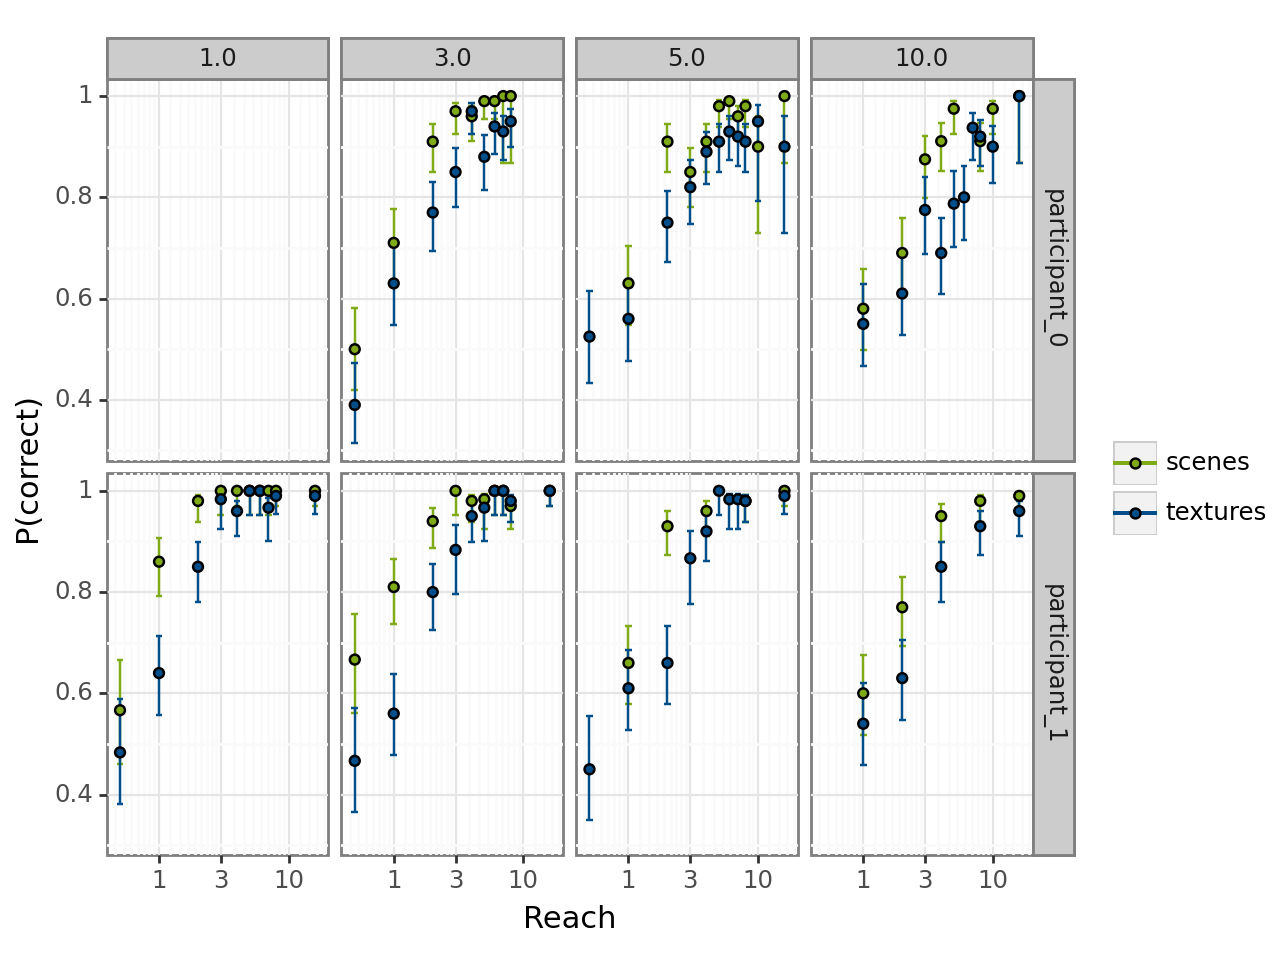

In [4]:
plt_1 = (
    pn.ggplot(
        data=grouped_df,
        mapping=pn.aes(
            x="reach",
            fill="image_condition",
            color="image_condition",
        ),
    )
    + pn.facet_grid("participant ~ grain")
    + pn.geom_errorbar(mapping=pn.aes(ymin="plot_lo", ymax="plot_hi"), width=0.0)
    + pn.geom_point(mapping=pn.aes(y="proportion_correct"), color="black")
    + pn.scale_x_log10()
    + pn.labs(x="Reach", y="P(correct)", color="", fill="")
    + pn.scale_color_manual(plot_colors)
    + pn.scale_fill_manual(plot_colors)
    + pn.theme_bw()
)
plt_1.save(top_dir / "figures" / "raw_psychometric_data.pdf", width=8, height=5)
plt_1.draw()

# Demo one fit to one cell of data

Here I will first demo a single psychometric function fit to one “cell”
of the data (one participant, condition, etc). This is essentially what
psignifit 4.0 is doing, with the important exception that here I am
using a binomial likelihood instead of the beta-binomial. (It would in
principle be possible to do this but I haven’t implemented it yet).

In [5]:
subset_df = grouped_df.loc[
    (grouped_df.participant == "participant_1")
    & (grouped_df.grain == 3.0)
    & (grouped_df.image_condition == "scenes")
    # (grouped_df.participant == "participant_0")
    # & (grouped_df.grain == 5.0)
    # & (grouped_df.image_condition == "scenes")
]
subset_df

reach grain image_condition    participant  n_successes  n_trials  \
5      0.5   3.0          scenes  participant_1         40.0      60.0   
21     1.0   3.0          scenes  participant_1         81.0     100.0   
37     2.0   3.0          scenes  participant_1         94.0     100.0   
53     3.0   3.0          scenes  participant_1         60.0      60.0   
69     4.0   3.0          scenes  participant_1         98.0     100.0   
85     5.0   3.0          scenes  participant_1         59.0      60.0   
101    6.0   3.0          scenes  participant_1         60.0      60.0   
117    7.0   3.0          scenes  participant_1         60.0      60.0   
133    8.0   3.0          scenes  participant_1         97.0     100.0   
165   16.0   3.0          scenes  participant_1        100.0     100.0   

     proportion_correct  n_failures  beta_lower  beta_mid  beta_upper  \
5              0.666667        20.0    0.560215  0.663035    0.756402   
21             0.810000        19.0    0.736305  0.805913    0.864735   
37             0.940000         6.0    0.886120  0.934182    0.967023   
53             1.000000         0.0    0.952076  0.988701    0.999159   
69             0.980000         2.0    0.938978  0.973612    0.991856   
85             0.983333         1.0    0.924578  0.972639    0.994143   
101            1.000000         0.0    0.952076  0.988701    0.999159   
117            1.000000         0.0    0.952076  0.988701    0.999159   
133            0.970000         3.0    0.925021  0.963764    0.986361   
165            1.000000         0.0    0.970775  0.993161    0.999492   

      plot_lo   plot_hi  
5    0.560215  0.756402  
21   0.736305  0.864735  
37   0.886120  0.967023  
53   0.952076  1.000000  
69   0.938978  0.991856  
85   0.924578  0.994143  
101  0.952076  1.000000  
117  0.952076  1.000000  
133  0.925021  0.986361  
165  0.970775  1.000000

## Model setup and sampling

To see the code that actually defines the model, look into the `model`
method of the `SinglePsychometricFunction` class.

Set up the model instance:

In [6]:
rng_key = random.PRNGKey(42)
m1 = SinglePsychometricFunction(
    data=subset_df, rng_key=rng_key, intensity_variable_name="reach"
)

Unfortunately rendering the model graph doesn’t seem to work with this
version of jax:

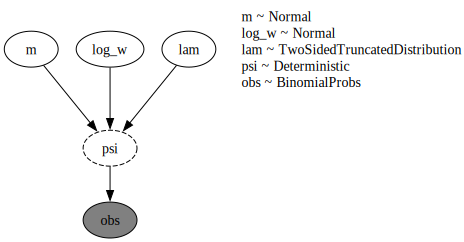

In [7]:
# render the model! (requires graphviz on system level)
m1_graph = numpyro.render_model(
    m1.model,
    render_distributions=True,
    render_params=True,
)
m1_graph.render(top_dir / "figures" / "m1_graph")
m1_graph

Sample from this model for all data:

In [8]:
m1.sample()

Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]





Running chain 0:   0%|          | 0/2000 [00:02<?, ?it/s]


Running chain 3: 100%|██████████| 2000/2000 [00:02<00:00, 989.84it/s]
/Users/tsawallis/HESSENBOX-DA/tsawallis/Projects/numpyro_psychometric_function_tutorial/src/numpyro_models.py:125: UserWarning: Sample's batch dimension size 4000 is different from the provided 50 num_samples argument. Defaulting to 4000.


In [9]:
m1.mcmc.print_summary(0.90)


                mean       std    median      5.0%     95.0%     n_eff     r_hat
       lam      0.01      0.01      0.01      0.00      0.02   2422.88      1.00
     log_w      1.13      0.23      1.12      0.76      1.52   1634.25      1.00
         m     -0.30      0.18     -0.29     -0.58     -0.01   1643.30      1.00

Number of divergences: 0


## Plot prior and posterior samples

Generate prior and posterior predictive samples from model.

In [10]:
x = jnp.logspace(jnp.log10(0.3), jnp.log10(16), 101)
new_df = pd.DataFrame({"reach": x})
prior_samples = m1.predict(data=new_df, prior=True, sample_obs=False)
posterior_samples = m1.predict(data=new_df, prior=False, sample_obs=False)
post_pred_mean = posterior_samples["psi"].mean(axis=0)
post_pred_hpdi = hpdi(posterior_samples["psi"], 0.9)
new_df["post_mean"] = post_pred_mean
new_df["post_lower"] = post_pred_hpdi[0]
new_df["post_upper"] = post_pred_hpdi[1]

Plot prior samples to see what sorts of curves are implied by our prior:

/Users/tsawallis/HESSENBOX-DA/tsawallis/Projects/numpyro_psychometric_function_tutorial/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 5 x 4 in image.
/Users/tsawallis/HESSENBOX-DA/tsawallis/Projects/numpyro_psychometric_function_tutorial/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /Users/tsawallis/HESSENBOX-DA/tsawallis/Projects/numpyro_psychometric_function_tutorial/figures/prior_samples.pdf


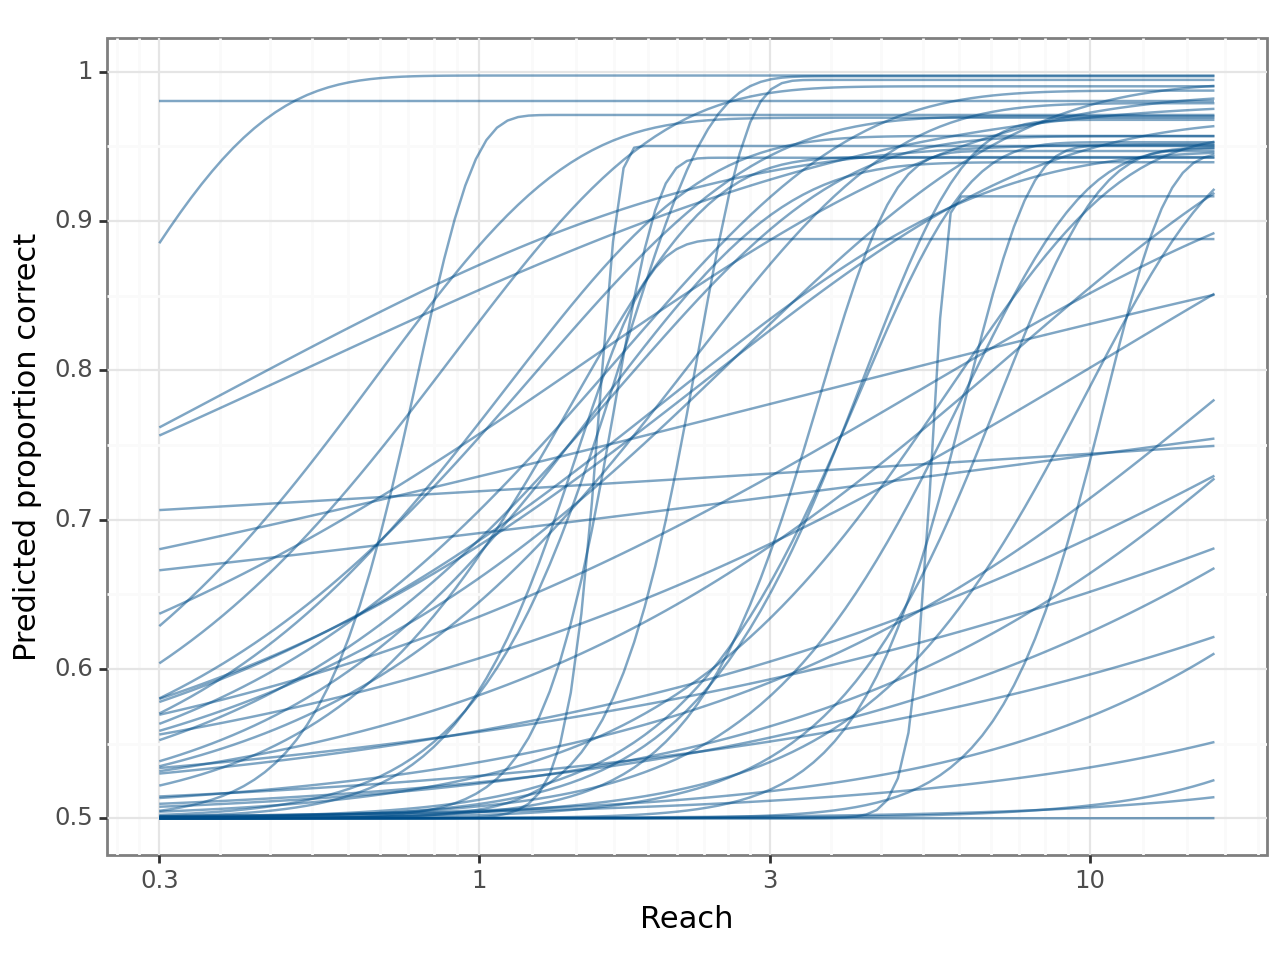

In [11]:
prior_samples_df = expand_grid(
    {"reach": x, "sample": range(prior_samples["psi"].shape[0])}
)
prior_samples_df["yhat"] = prior_samples["psi"].reshape(
    len(prior_samples_df), order="F"
)
prior_samples_df["reach"] = prior_samples_df["reach"].astype(float)

plt_prior_samples = (
    (
        pn.ggplot(
            data=prior_samples_df, mapping=pn.aes(x="reach", y="yhat", group="sample")
        )
    )
    + pn.geom_line(alpha=0.5, color=plot_colors[1])
    + pn.scale_x_log10()
    + pn.theme_bw()
    + pn.labs(x="Reach", y="Predicted proportion correct")
)

plt_prior_samples.save(top_dir / "figures" / "prior_samples.pdf", width=5, height=4)
plt_prior_samples.draw()

Plot the mean and HPDI of the psychometric curve:

/Users/tsawallis/HESSENBOX-DA/tsawallis/Projects/numpyro_psychometric_function_tutorial/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 5 x 4 in image.
/Users/tsawallis/HESSENBOX-DA/tsawallis/Projects/numpyro_psychometric_function_tutorial/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /Users/tsawallis/HESSENBOX-DA/tsawallis/Projects/numpyro_psychometric_function_tutorial/figures/single_psychometric_function.pdf


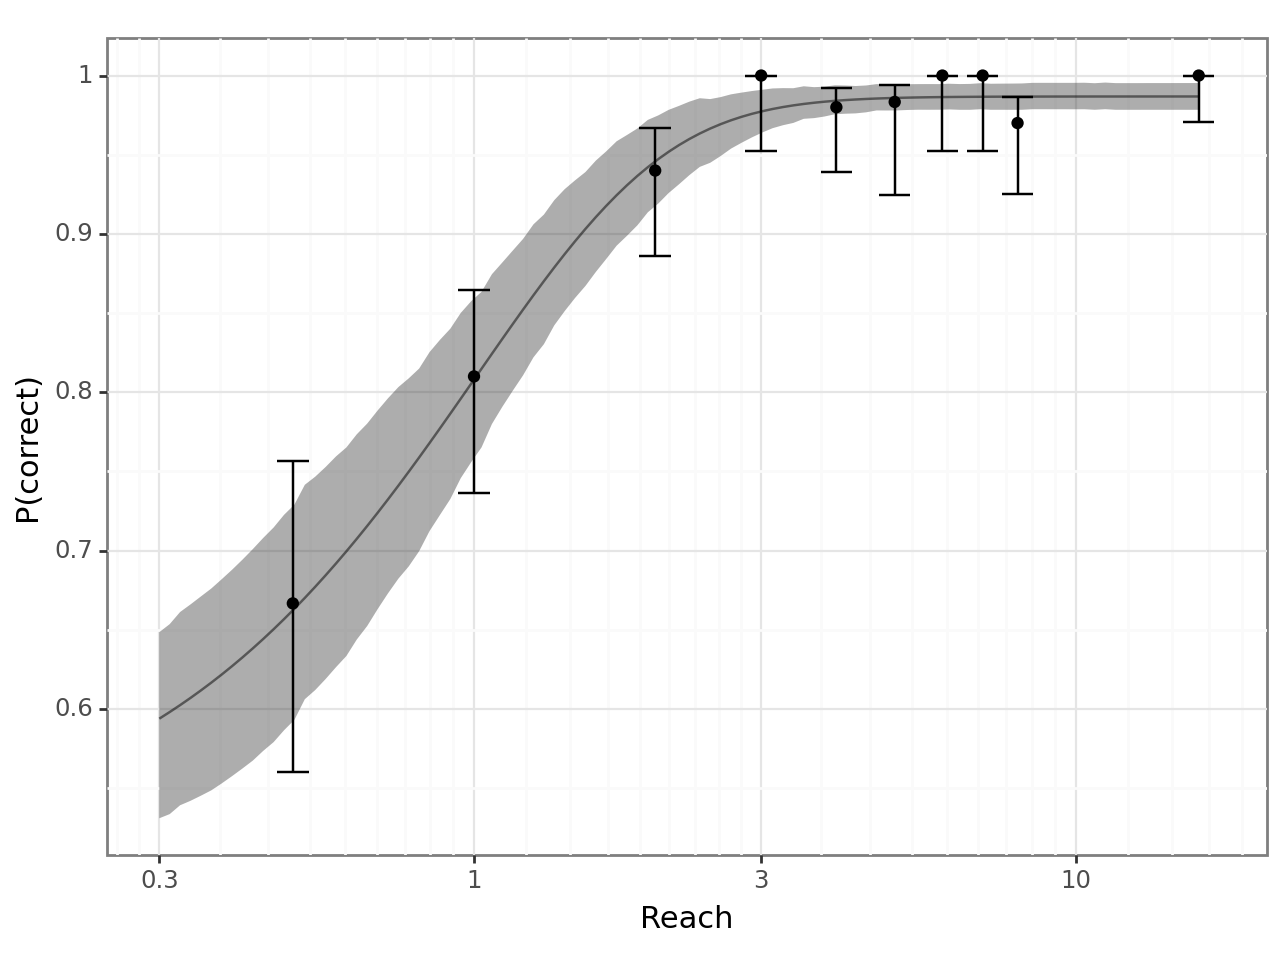

In [12]:
plt_2 = (
    pn.ggplot(
        data=subset_df,
        mapping=pn.aes(
            x="reach",
        ),
    )
    + pn.geom_ribbon(
        data=new_df,
        mapping=pn.aes(
            ymin="post_lower",
            ymax="post_upper",
        ),
        color=None,
        outline_type="full",
        alpha=0.4,
    )
    + pn.geom_line(
        data=new_df,
        mapping=pn.aes(y="post_mean"),
        alpha=0.5,
    )
    + pn.geom_errorbar(mapping=pn.aes(ymin="plot_lo", ymax="plot_hi"), width=0.0)
    + pn.geom_point(mapping=pn.aes(y="proportion_correct"), color="black")
    + pn.scale_x_log10()
    + pn.labs(x="Reach", y="P(correct)", color="", fill="")
    + pn.theme_bw()
)

plt_2.save(top_dir / "figures" / "single_psychometric_function.pdf", width=5, height=4)
plt_2.draw()

## Examine parameter distributions

Plot parameter distributions using
[arviz](https://python.arviz.org/en/latest/index.html):

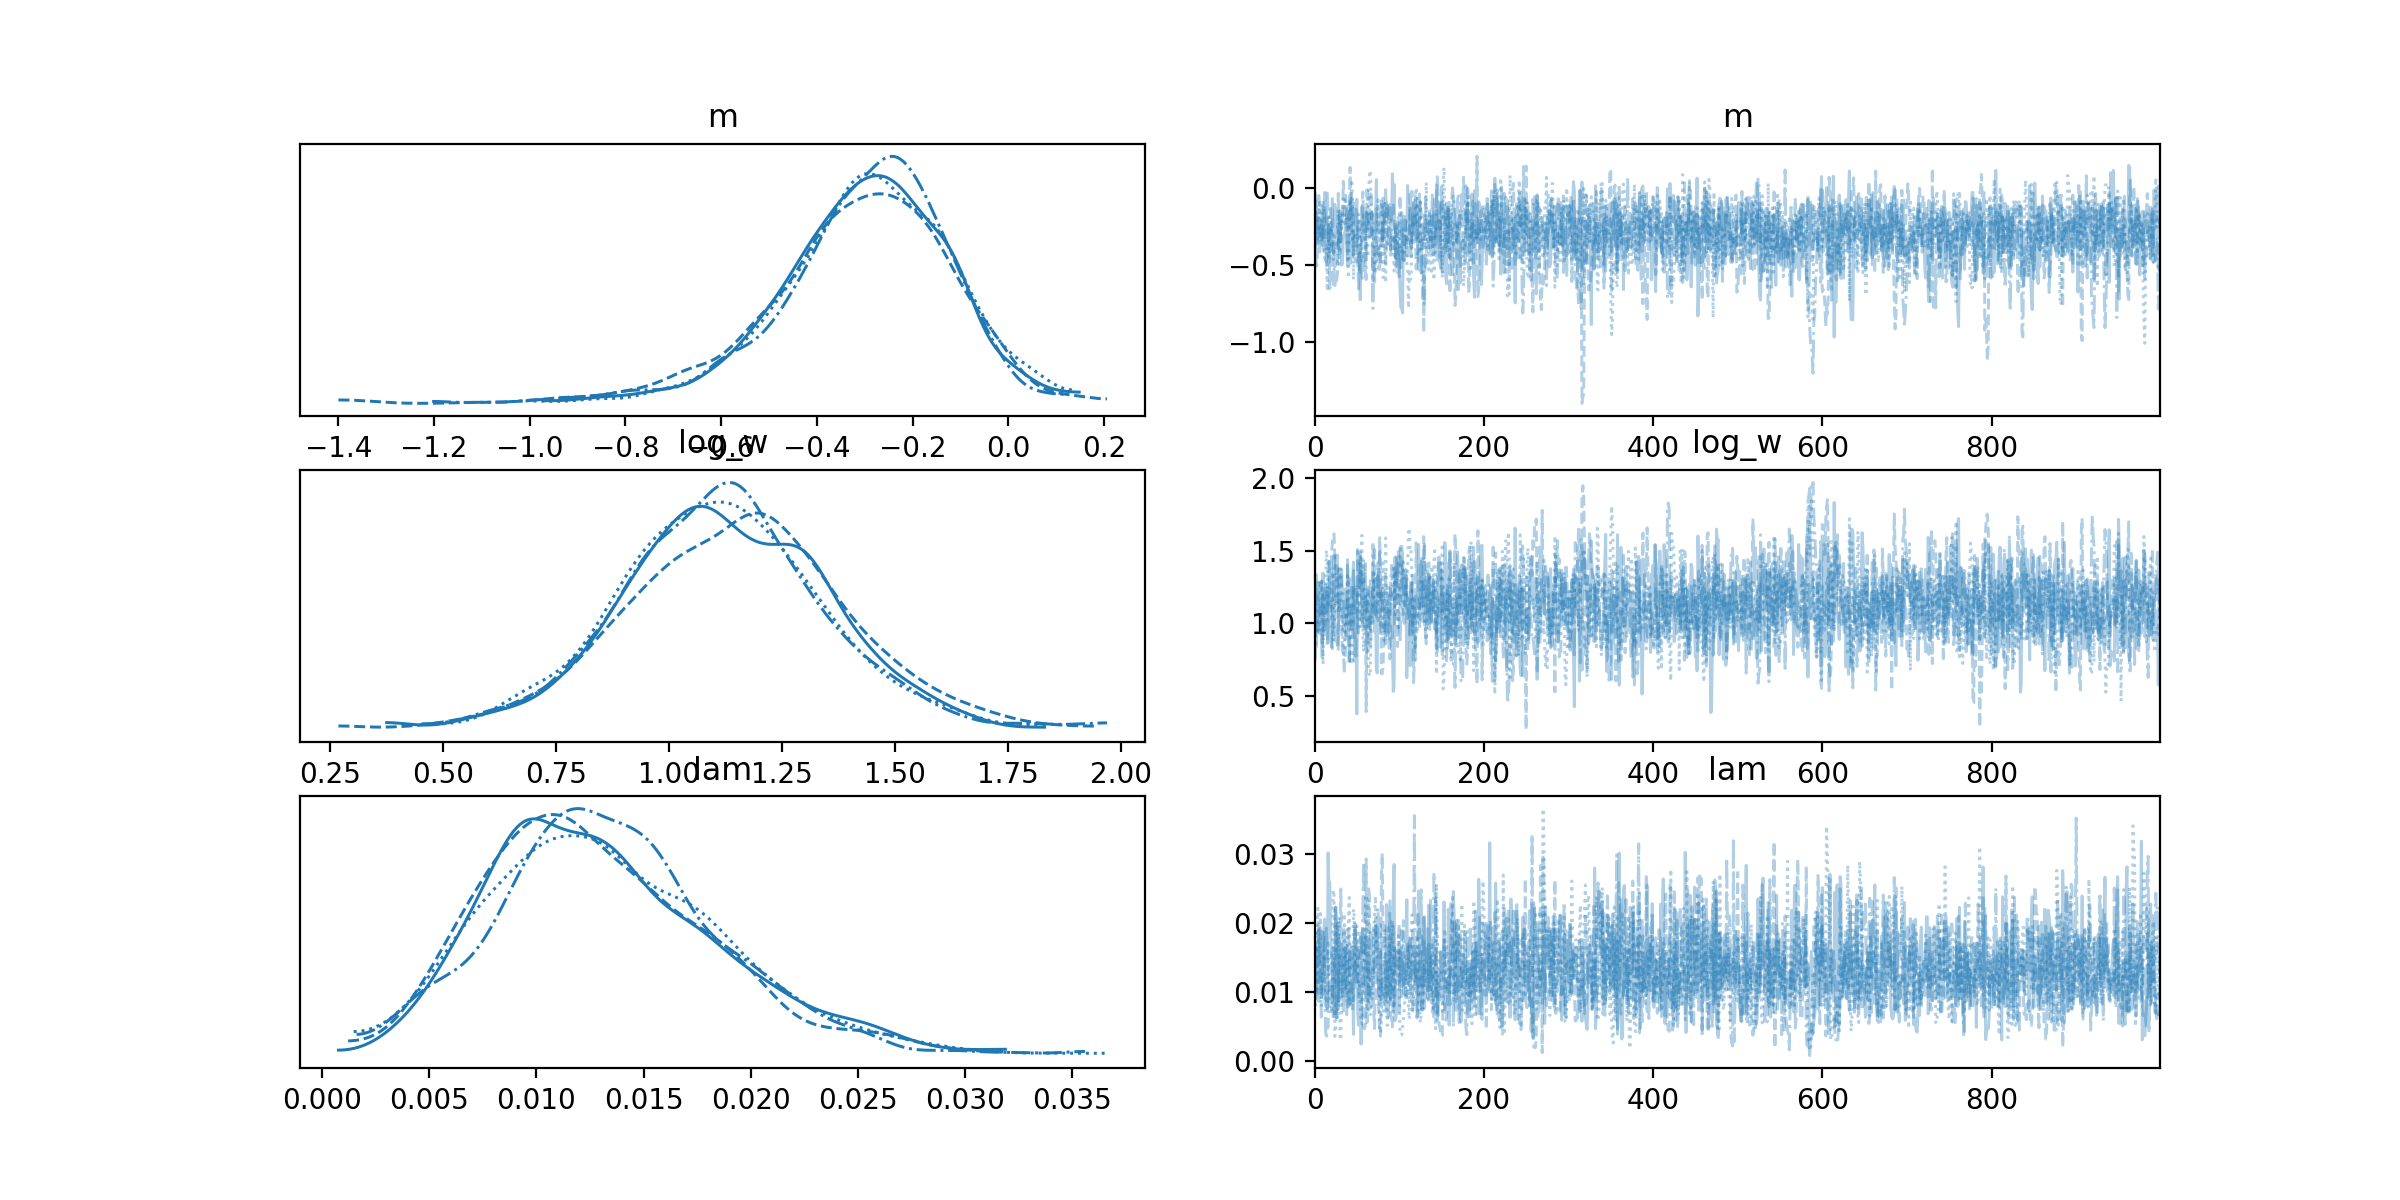

In [13]:
az.plot_trace(m1.mcmc, var_names=["m", "log_w", "lam"])
plt.show()

Plot prior vs posterior for threshold `m`:

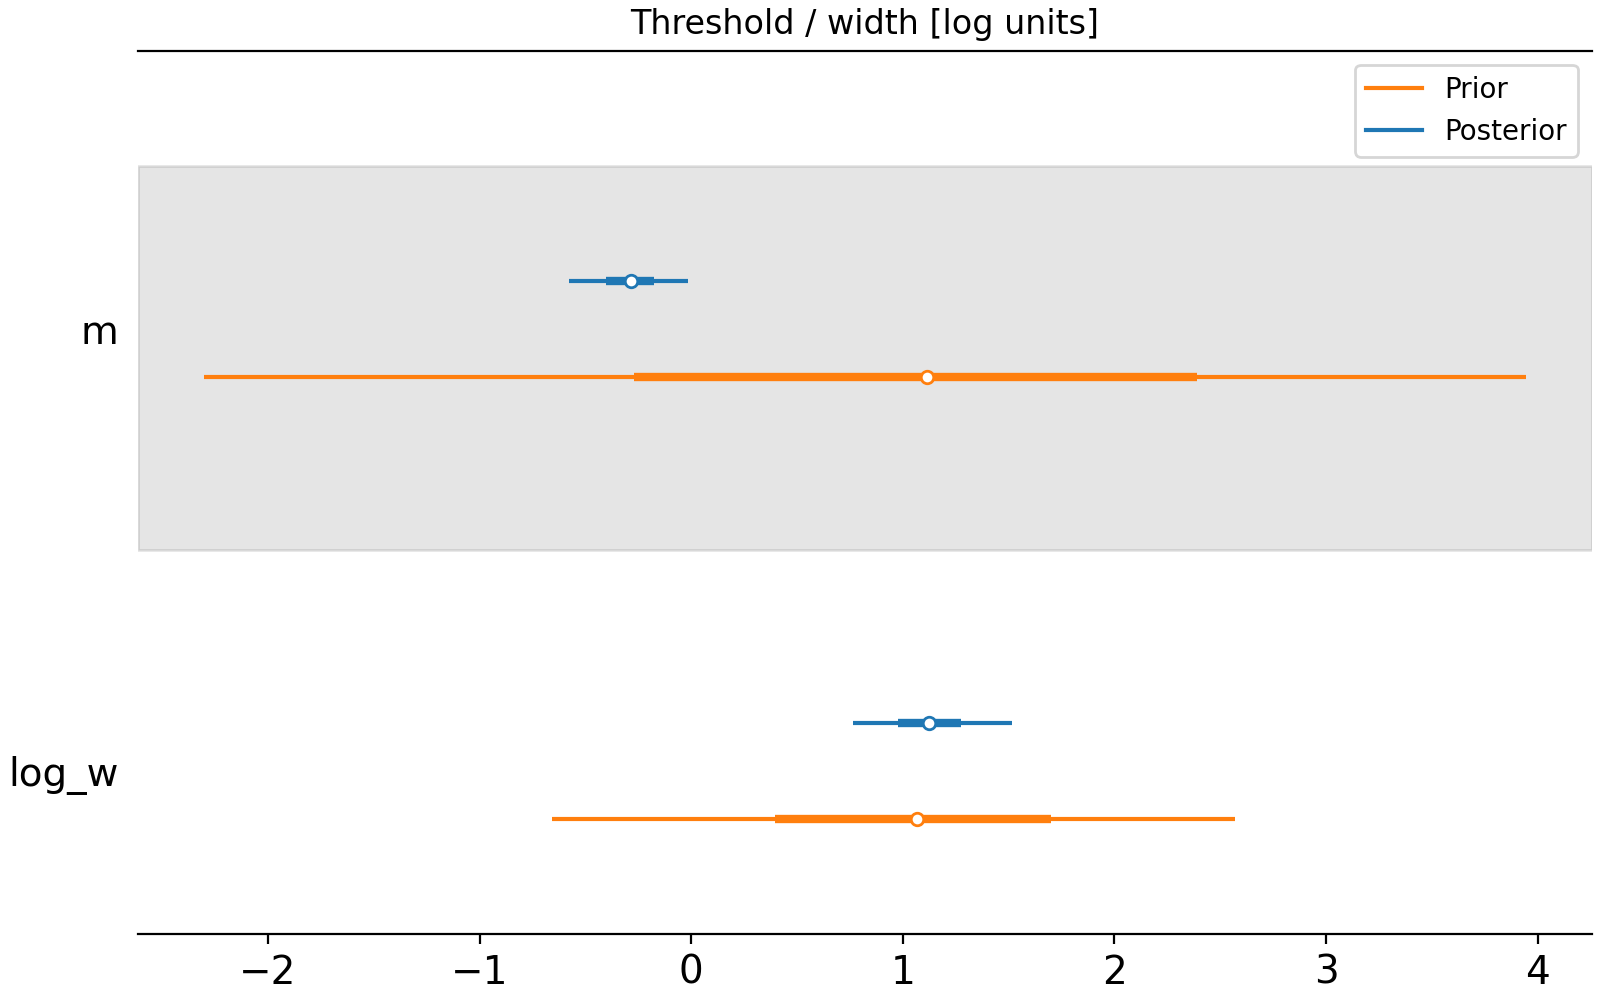

In [14]:
model_list = [m1.arviz_data["posterior"], m1.arviz_data["prior"]]
model_names = ["Posterior", "Prior"]

fig, ax = plt.subplots(1, 1, figsize=(8, 5), layout="constrained")
ax = az.plot_forest(
    model_list,
    model_names=model_names,
    kind="forestplot",
    var_names=["m", "log_w"],
    hdi_prob=0.9,
    combined=True,
    ridgeplot_overlap=1.5,
    ax=ax,
)
ax[0].set_title("Threshold / width [log units]")
plt.show()

# Separate fits to each cell

With this single-condition model, we’re now going to loop over each cell
of the data, fitting each one, and storing the results. This will allow
us to compare the multi-level model fit below.

Note that here I’m going to do this in a separate script, in order to
reduce the compute time for this notebook. See the code in
`fit_single_cells.py` to see how this works. We can just load this file
up:

In [15]:
data_file = top_dir / "results" / "single_psychometric_fits.xz"
with lzma.open(data_file, "r") as f:
    tmp = f.read()
    model_dict, pred_df = pickle.loads(tmp)

model_dict

{('participant_1',
  1.0,
  'scenes'): {'model': <src.numpyro_models.SinglePsychometricFunction at 0x31c1f6550>, 'prior_samples': {'lam': Array([0.03870377, 0.050756  , 0.04801546, 0.02969311, 0.03987225,
          0.03356363, 0.03215481, 0.00540076, 0.01959392, 0.04371279,
          0.02889378, 0.0317429 , 0.0061145 , 0.04149739, 0.02116073,
          0.04251004, 0.00969706, 0.04294571, 0.03073602, 0.0437172 ,
          0.00248564, 0.11202895, 0.05237924, 0.03281031, 0.05306126,
          0.04713699, 0.04931489, 0.08338828, 0.03027897, 0.02102736,
          0.04815697, 0.00689919, 0.0480587 , 0.08338118, 0.01257699,
          0.06056336, 0.04305119, 0.01467788, 0.00722913, 0.04967143,
          0.05116526, 0.04590566, 0.00293142, 0.0528701 , 0.05754479,
          0.05416035, 0.05699337, 0.05713782, 0.00801905, 0.04311592],      dtype=float32),
   'log_w': Array([ 1.4758303 ,  0.4068472 ,  1.5007335 ,  1.2317694 ,  1.9379815 ,
           4.0946107 ,  0.41893423, -0.27876124,  0.6232657

## Plot individual psychometric functions

/Users/tsawallis/HESSENBOX-DA/tsawallis/Projects/numpyro_psychometric_function_tutorial/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 8 x 5 in image.
/Users/tsawallis/HESSENBOX-DA/tsawallis/Projects/numpyro_psychometric_function_tutorial/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /Users/tsawallis/HESSENBOX-DA/tsawallis/Projects/numpyro_psychometric_function_tutorial/figures/m0_psychometric_functions.pdf


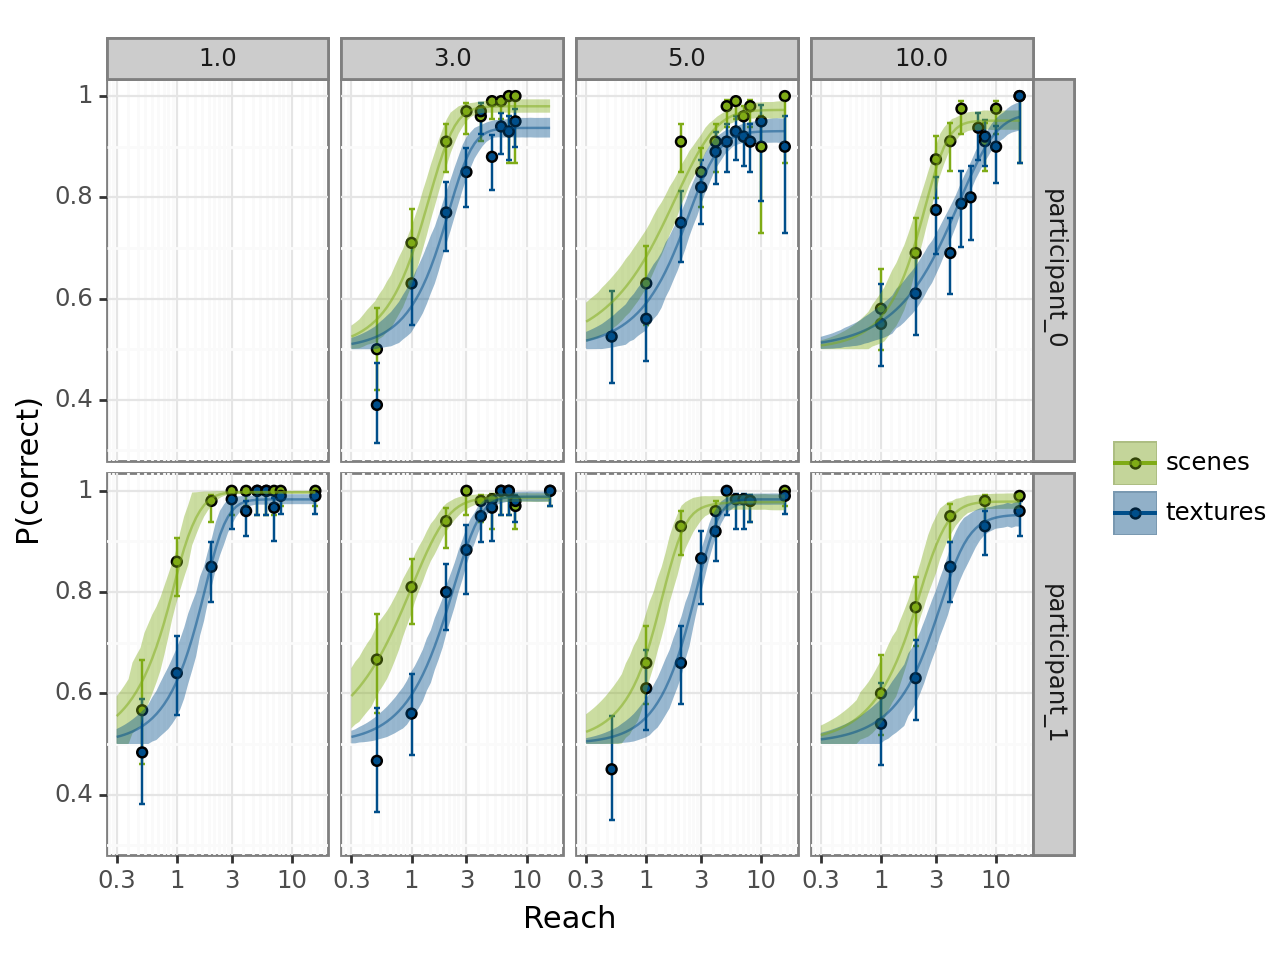

In [16]:
plt_3 = plt_1
plt_3 = (
    plt_3
    + pn.geom_ribbon(
        data=pred_df,
        mapping=pn.aes(
            ymin="post_lower",
            ymax="post_upper",
        ),
        color=None,
        outline_type="full",
        alpha=0.4,
    )
    + pn.geom_line(
        data=pred_df,
        mapping=pn.aes(y="post_mean"),
        alpha=0.5,
    )
)

plt_3.save(top_dir / "figures" / "m0_psychometric_functions.pdf", width=8, height=5)
plt_3.draw()

## Plot parameter estimates

Pull out info into lists:

In [17]:
model_list = []
model_names = []
for participant, grain, image_condition in model_dict.keys():
    model_list.append(
        model_dict[(participant, grain, image_condition)]["model"].arviz_data
    )
    model_names.append(f"{participant}, {grain}, {image_condition}")

### Plot threshold estimates

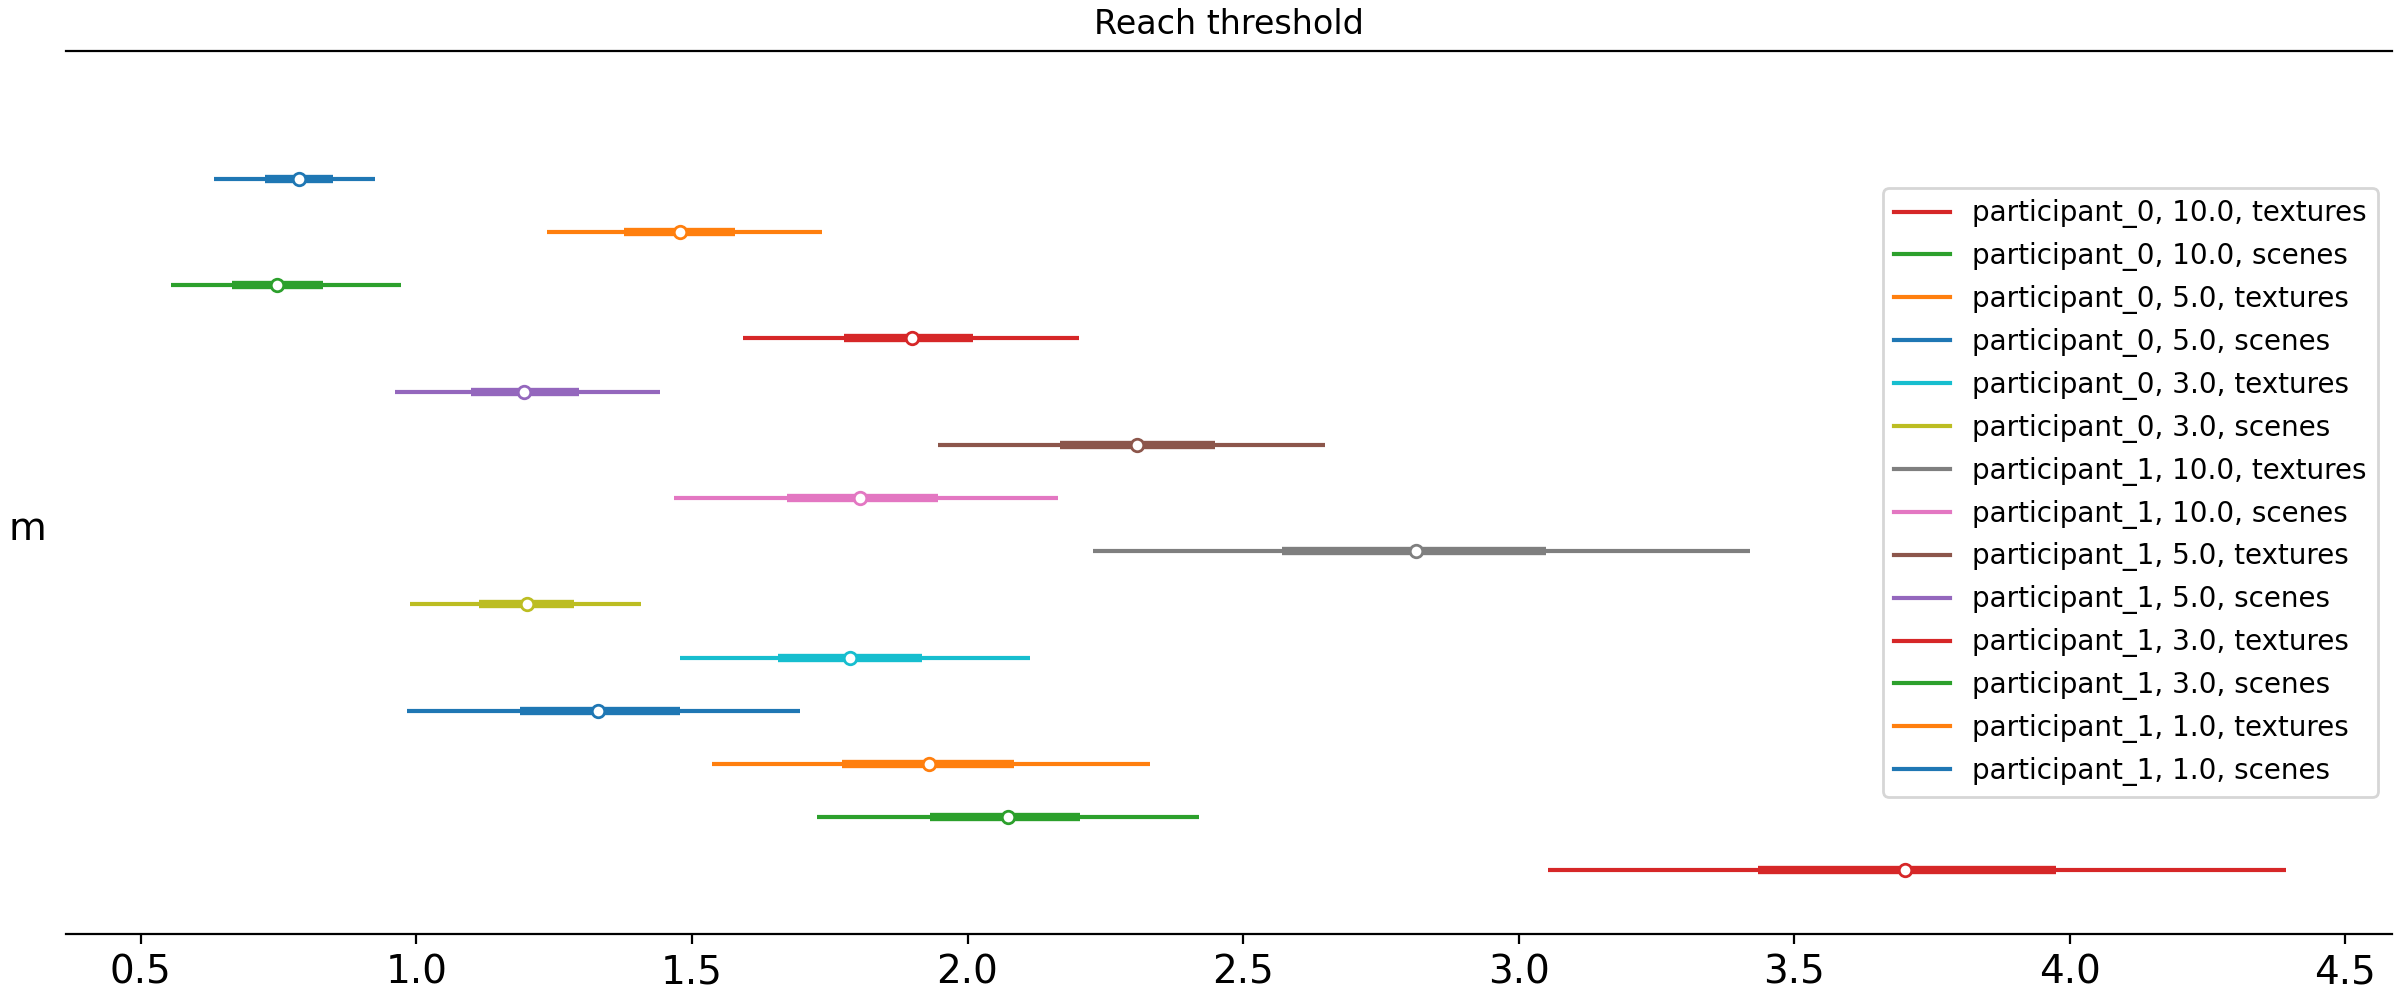

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5), layout="constrained")
ax = az.plot_forest(
    model_list,
    model_names=model_names,
    kind="forestplot",
    var_names=["m"],
    transform=np.exp,
    hdi_prob=0.9,
    combined=True,
    ridgeplot_overlap=1.5,
    ax=ax,
)
ax[0].set_title("Reach threshold")
plt.show()

We could do more plots of the different parameters of course, but this
becomes more relevant when we’re comparing to other models below.

# Multilevel model with participants in conditions

Now we’re going to do a multilevel model with participants acting in
conditions.

We create a new grouped df dataframe here, ungrouping by source image,
in order to compare to the image-random effects model below. Note that
this is not strictly necessary for this model and actually makes the
sampling less efficient.

In [19]:
# create a binomial grouped data structure:
grouped_image_df = group_bernoulli_trials_into_binomial(
    df,
    stimulus_intensity="reach",
    experiment_conditions=["grain", "image_condition"],
    group_variables=["participant", "image_name"],
    bernoulli_outcome_column="correct",
    use_rule_of_succession=True,
)
grouped_image_df = grouped_image_df.dropna()
grouped_image_df

/Users/tsawallis/HESSENBOX-DA/tsawallis/Projects/numpyro_psychometric_function_tutorial/src/numpyro_models.py:953: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


reach grain image_condition    participant           image_name  \
49      0.5   1.0          scenes  participant_1                 0387   
57      0.5   1.0          scenes  participant_1        asparagus_04s   
58      0.5   1.0          scenes  participant_1  basketball_hoop_07s   
59      0.5   1.0          scenes  participant_1  basketball_hoop_09s   
61      0.5   1.0          scenes  participant_1          bedpost_04s   
...     ...   ...             ...            ...                  ...   
7016   16.0  10.0        textures  participant_1           abacus_10s   
7020   16.0  10.0        textures  participant_1             bear_09s   
7023   16.0  10.0        textures  participant_1             boar_04s   
7035   16.0  10.0        textures  participant_1           clover_14s   
7037   16.0  10.0        textures  participant_1          coconut_17n   

      n_successes  n_trials  proportion_correct  n_failures  beta_lower  \
49            2.0       3.0            0.666667         1.0    0.248605   
57            2.0       3.0            0.666667         1.0    0.248605   
58            3.0       3.0            1.000000         0.0    0.472871   
59            1.0       3.0            0.333333         2.0    0.097611   
61            3.0       3.0            1.000000         0.0    0.472871   
...           ...       ...                 ...         ...         ...   
7016          5.0       5.0            1.000000         0.0    0.606962   
7020          5.0       5.0            1.000000         0.0    0.606962   
7023          5.0       5.0            1.000000         0.0    0.606962   
7035          5.0       5.0            1.000000         0.0    0.606962   
7037          5.0       5.0            1.000000         0.0    0.606962   

      beta_mid  beta_upper   plot_lo   plot_hi  
49    0.614272    0.902389  0.248605  0.902389  
57    0.614272    0.902389  0.248605  0.902389  
58    0.840896    0.987259  0.472871  1.000000  
59    0.385728    0.751395  0.097611  0.751395  
61    0.840896    0.987259  0.472871  1.000000  
...        ...         ...       ...       ...  
7016  0.890899    0.991488  0.606962  1.000000  
7020  0.890899    0.991488  0.606962  1.000000  
7023  0.890899    0.991488  0.606962  1.000000  
7035  0.890899    0.991488  0.606962  1.000000  
7037  0.890899    0.991488  0.606962  1.000000  

[2440 rows x 14 columns]

In [20]:
rng_key = random.PRNGKey(42)
m2 = ParticipantsAllConditions(
    data=grouped_image_df,
    rng_key=rng_key,
    intensity_variable_name="reach",
    experiment_conditions=["image_condition", "grain"],
    group_variables=["participant"],
    use_reparam=True,
)

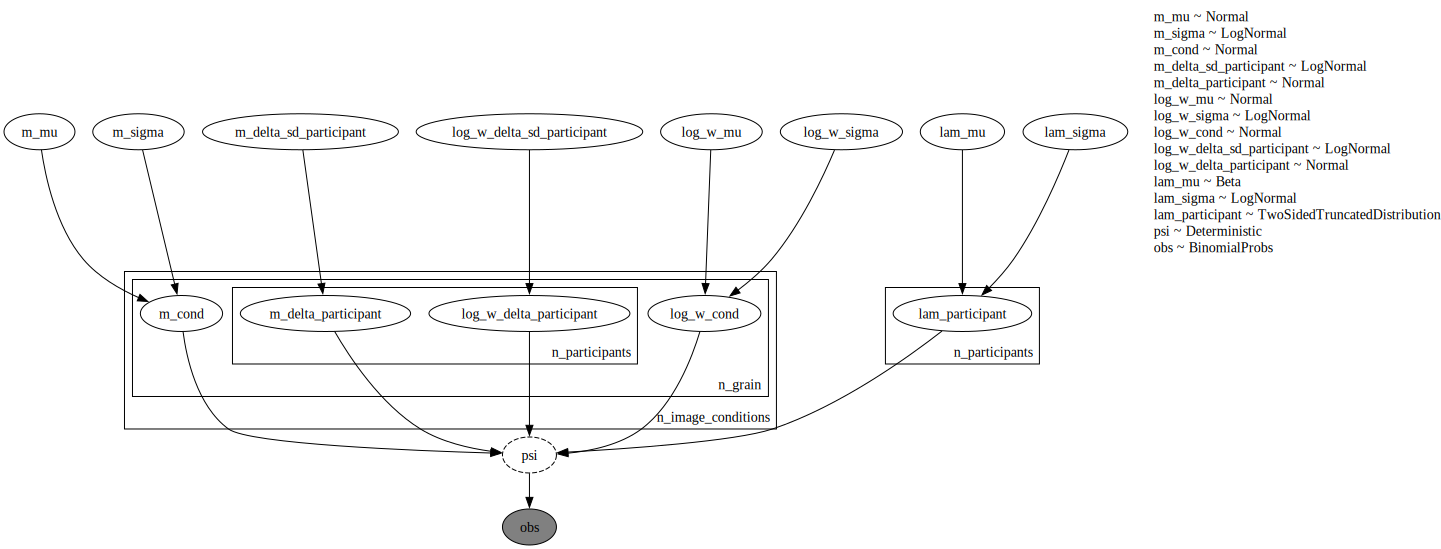

In [21]:
# render the model! (requires graphviz on system level)

# note to simplify we will exclude the reparam:
m2_tmp = ParticipantsAllConditions(
    data=grouped_image_df,
    rng_key=rng_key,
    intensity_variable_name="reach",
    experiment_conditions=["image_condition", "grain"],
    group_variables=["participant"],
    use_reparam=False,
)
m2_graph = numpyro.render_model(
    m2_tmp.model,
    render_distributions=True,
    render_params=True,
)
m2_graph.render(top_dir / "figures" / "m2_graph")
m2_graph

## Sample the model and check the overall output

Sample from this model for all data:

In [22]:
m2.sample(num_warmup=4000, num_samples=2000)

Compiling.. :   0%|          | 0/6000 [00:00<?, ?it/s]





Running chain 0:   0%|          | 0/6000 [00:08<?, ?it/s]


Running chain 0:   5%|▌         | 300/6000 [00:11<01:02, 91.59it/s]



Running chain 0:  10%|█         | 600/6000 [00:13<00:41, 131.05it/s]


Running chain 0:  15%|█▌        | 900/6000 [00:14<00:29, 171.46it/s]


Running chain 0:  20%|██        | 1200/6000 [00:15<00:24, 194.03it/s]


Running chain 0:  25%|██▌       | 1500/6000 [00:16<00:20, 214.63it/s]


Running chain 0:  30%|███       | 1800/6000 [00:17<00:19, 218.80it/s]


Running chain 0:  35%|███▌      | 2100/6000 [00:19<00:16, 232.13it/s]


Running chain 0:  40%|████      | 2400/6000 [00:20<00:15, 226.36it/s]


Running chain 0:  45%|████▌     | 2700/6000 [00:21<00:13, 243.38it/s]


Running chain 0:  50%|█████     | 3000/6000 [00:22<00:11, 257.47it/s]


Running chain 0:  55%|█████▌    | 3300/6000 [00:23<00:10, 267.01it/s]


Running chain 0:  60%|██████    | 3600/6000 [00:24<00:08, 275.21it/s]


Running chain 0:  6

In [23]:
m2.mcmc.print_summary(0.90)


                                               mean       std    median      5.0%     95.0%     n_eff     r_hat
                                   lam_mu      0.07      0.07      0.05      0.00      0.17   9996.94      1.00
                       lam_participant[0]      0.05      0.01      0.05      0.04      0.06   6419.76      1.00
                       lam_participant[1]      0.01      0.00      0.01      0.01      0.01   9170.63      1.00
                                lam_sigma      0.56      0.75      0.33      0.01      1.25   6698.58      1.00
               log_w_cond_decentered[0,0]     -0.43      0.91     -0.45     -1.98      1.01   8406.90      1.00
               log_w_cond_decentered[0,1]     -0.24      0.79     -0.24     -1.51      1.05   7052.02      1.00
               log_w_cond_decentered[0,2]      0.32      0.87      0.34     -1.07      1.80   6915.11      1.00
               log_w_cond_decentered[0,3]     -0.27      0.81     -0.27     -1.62      1.04   7331.72  

Check that our participant offsets have mean of approx zero:

In [24]:
for i, j in product(
    range(len(grouped_df.image_condition.unique())),
    range(len(grouped_df.grain.unique())),
):
    tmp = m2.posterior_samples["m_delta_participant"][:, i, j]
    print(f"mean: {tmp.mean()}, var: {tmp.std()}")

mean: 0.025217991322278976, var: 0.0984904021024704
mean: 0.004060408100485802, var: 0.0952734723687172
mean: 0.004060408100485802, var: 0.0952734723687172
mean: 0.004060408100485802, var: 0.0952734723687172
mean: -0.026100710034370422, var: 0.09966457635164261
mean: -0.003069132100790739, var: 0.09558029472827911
mean: -0.003069132100790739, var: 0.09558029472827911
mean: -0.003069132100790739, var: 0.09558029472827911


## Plot psychometric functions

First generate some example data and predictions.

/Users/tsawallis/HESSENBOX-DA/tsawallis/Projects/numpyro_psychometric_function_tutorial/src/numpyro_models.py:125: UserWarning: Sample's batch dimension size 8000 is different from the provided 50 num_samples argument. Defaulting to 8000.
/Users/tsawallis/HESSENBOX-DA/tsawallis/Projects/numpyro_psychometric_function_tutorial/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 8 x 5 in image.
/Users/tsawallis/HESSENBOX-DA/tsawallis/Projects/numpyro_psychometric_function_tutorial/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /Users/tsawallis/HESSENBOX-DA/tsawallis/Projects/numpyro_psychometric_function_tutorial/figures/m2_psychometric_functions.pdf


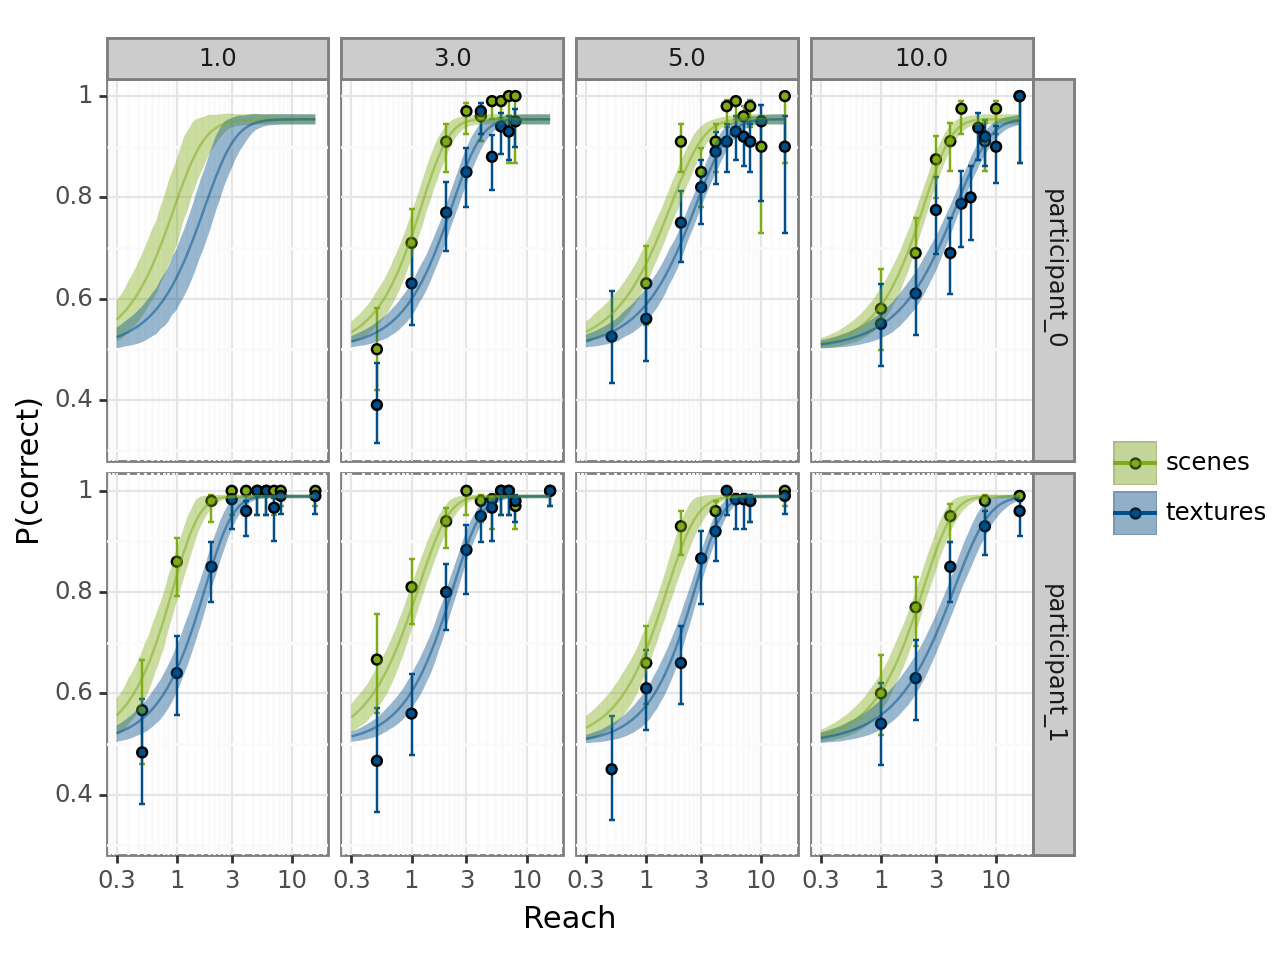

In [25]:
x = np.logspace(np.log10(0.3), np.log10(16), 51)
pred_df = expand_grid(
    {
        "reach": x,
        "participant": grouped_df["participant"].unique(),
        "grain": grouped_df["grain"].unique(),
        "image_condition": grouped_df["image_condition"].unique(),
    }
)
pred_df, _ = PsychometricFunctionWrapper.create_grouping_ids(
    pred_df,
    experiment_conditions=["image_condition", "grain"],
    group_variables=["participant"],
)

# prior_samples = m2.predict(data=pred_df, prior=True, sample_obs=False)
posterior_samples = m2.predict(data=pred_df, prior=False, sample_obs=False)
post_pred_mean = posterior_samples["psi"].mean(axis=0)
post_pred_hpdi = hpdi(posterior_samples["psi"], 0.9)
pred_df["post_mean"] = post_pred_mean
pred_df["post_lower"] = post_pred_hpdi[0]
pred_df["post_upper"] = post_pred_hpdi[1]

plt_4 = plt_1
plt_4 = (
    plt_4
    + pn.geom_ribbon(
        data=pred_df,
        mapping=pn.aes(
            ymin="post_lower",
            ymax="post_upper",
        ),
        color=None,
        outline_type="full",
        alpha=0.4,
    )
    + pn.geom_line(
        data=pred_df,
        mapping=pn.aes(y="post_mean"),
        alpha=0.5,
    )
)
plt_4.save(top_dir / "figures" / "m2_psychometric_functions.pdf", width=8, height=5)
plt_4.draw()

Compare this plot to the independent version above.

## Plot parameter estimates

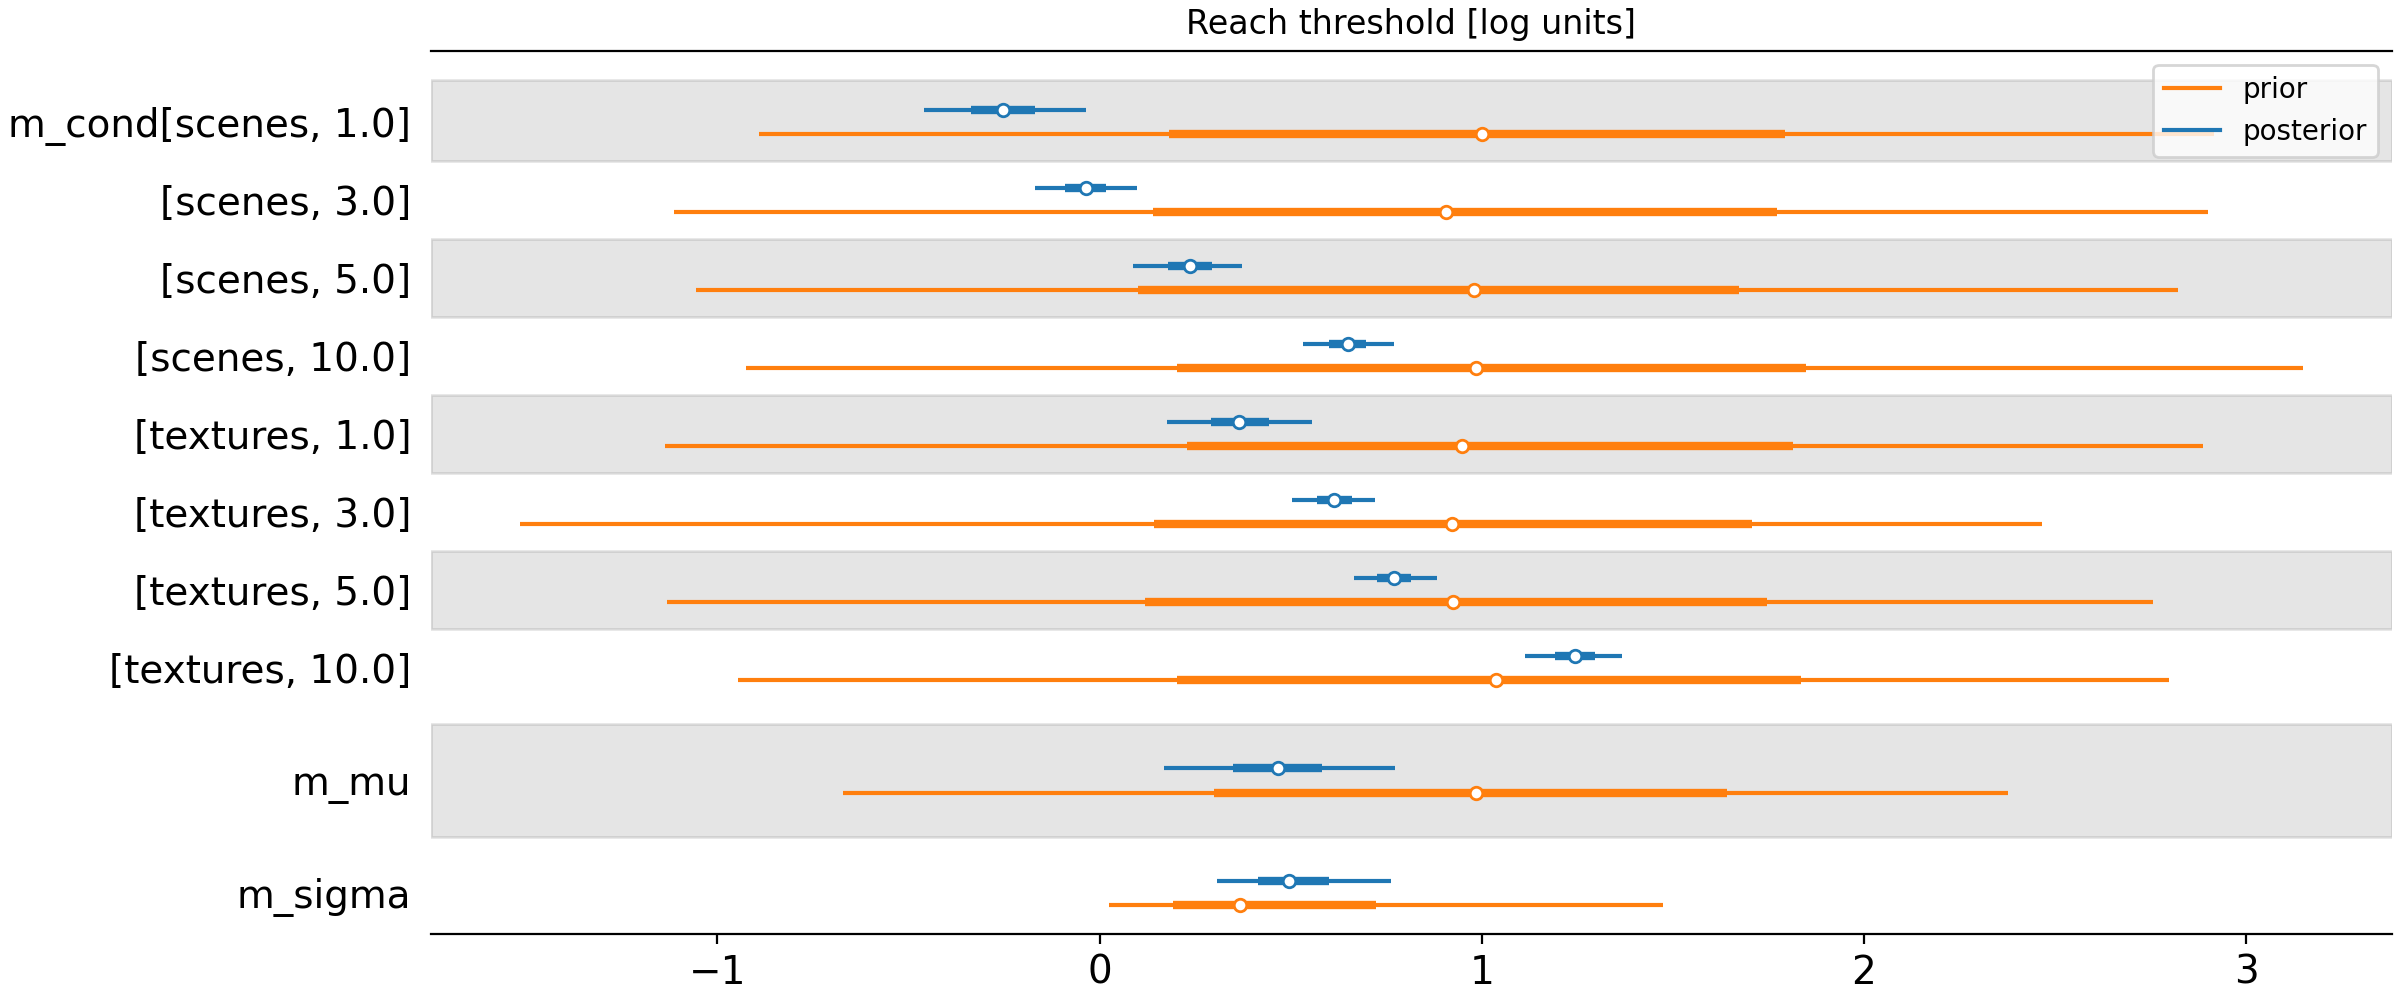

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5), layout="constrained")
ax = az.plot_forest(
    [m2.arviz_data["posterior"], m2.arviz_data["prior"]],
    model_names=["posterior", "prior"],
    kind="forestplot",
    var_names=["m_cond", "m_mu", "m_sigma"],
    # transform=np.exp,
    hdi_prob=0.9,
    combined=True,
    ridgeplot_overlap=1.5,
    ax=ax,
)
ax[0].set_title("Reach threshold [log units]")
plt.show()

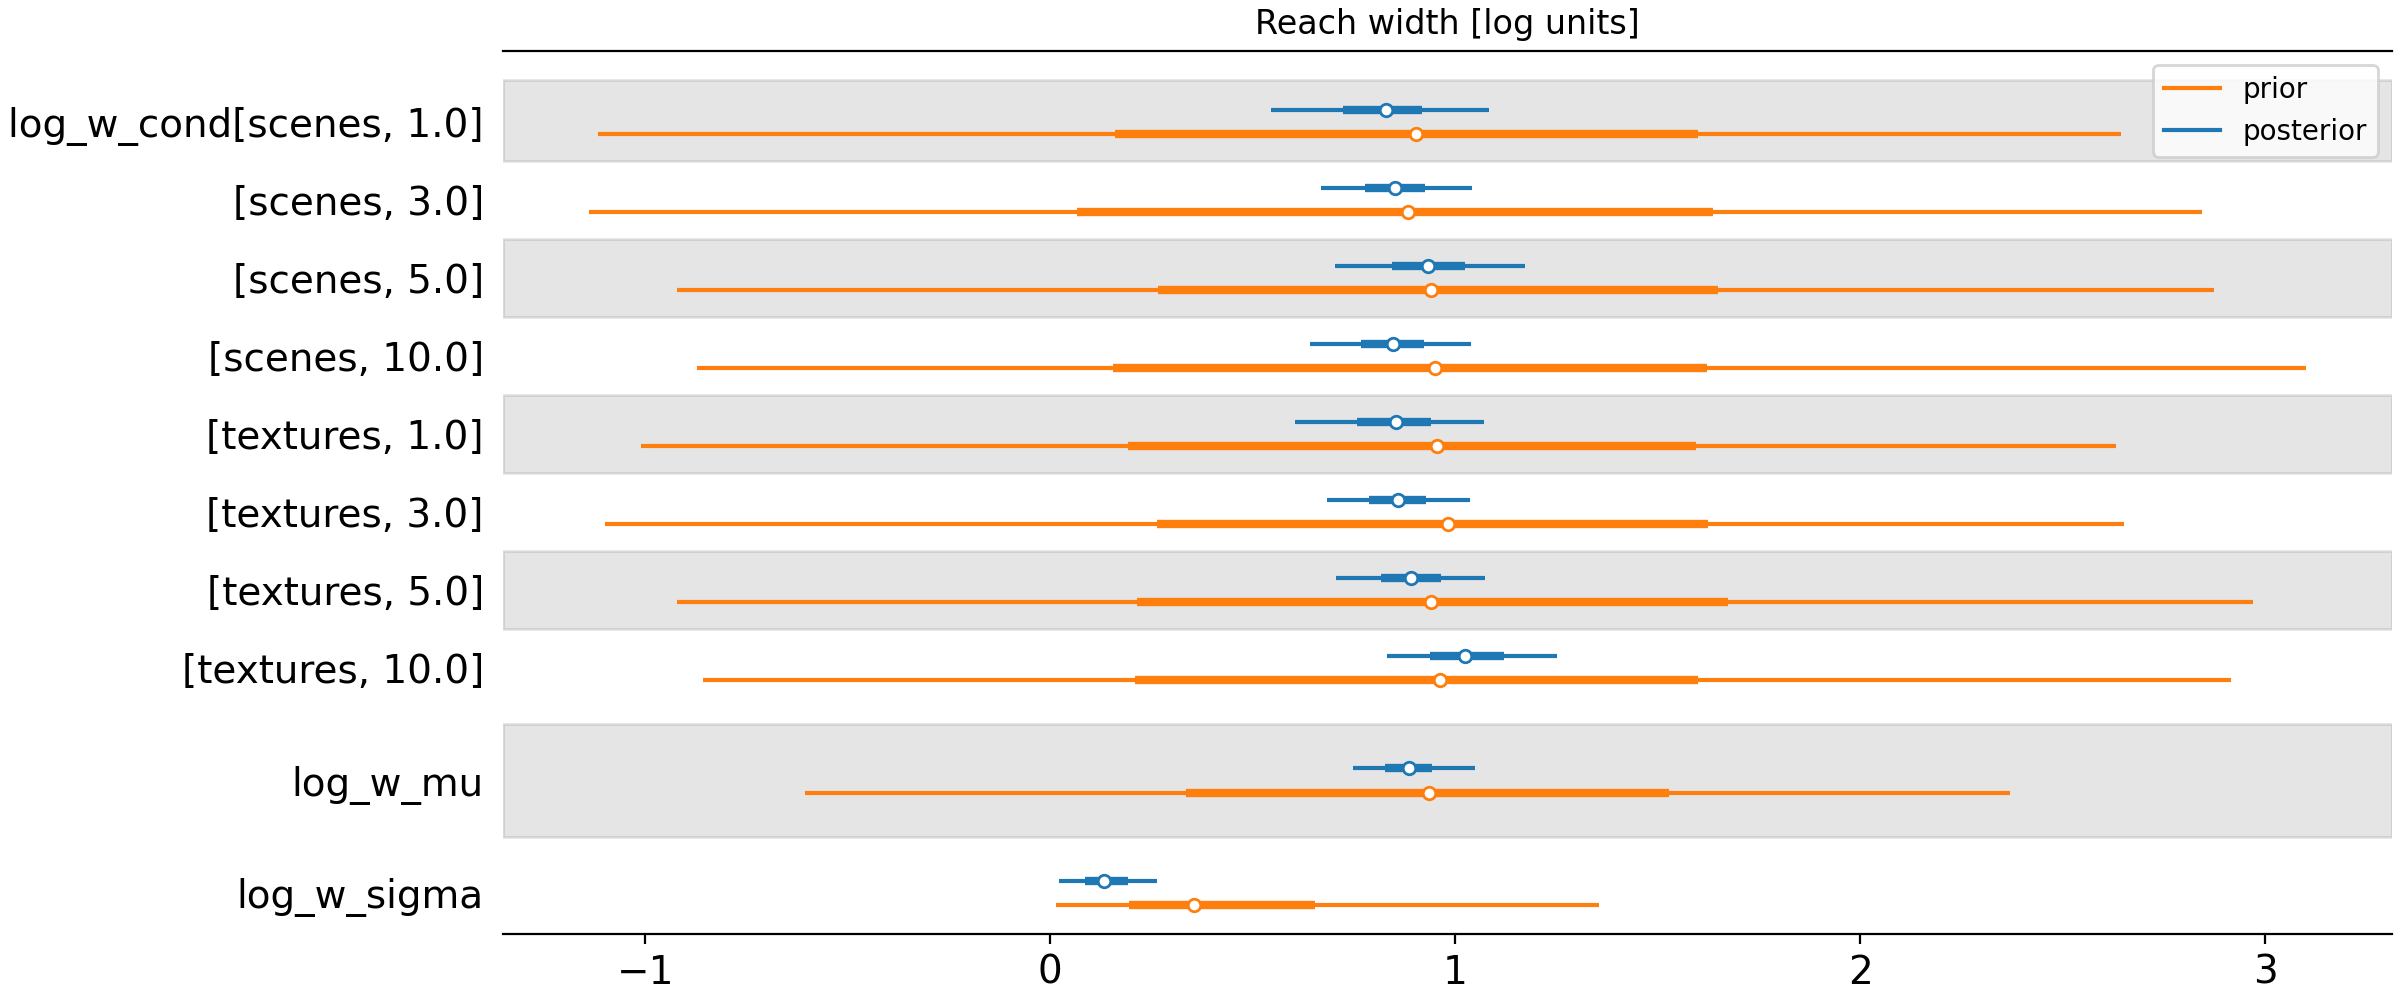

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5), layout="constrained")
ax = az.plot_forest(
    [m2.arviz_data["posterior"], m2.arviz_data["prior"]],
    model_names=["posterior", "prior"],
    kind="forestplot",
    var_names=["log_w_cond", "log_w_mu", "log_w_sigma"],
    # transform=np.exp,
    hdi_prob=0.9,
    combined=True,
    ridgeplot_overlap=1.5,
    ax=ax,
)
ax[0].set_title("Reach width [log units]")
plt.show()

## Example difference estimate

As an example for how we could now compare conditions, we could ask:
what is the posterior distribution on the threshold difference between
scenes and textures, averaging over grain?

For the syntax from Arviz, see
[here](https://python.arviz.org/en/stable/getting_started/WorkingWithInferenceData.html#compute-and-store-posterior-pushforward-quantities).

In [28]:
# extract posterior to make this easier to work with:
post = m2.arviz_data.posterior

Compute difference score for each image condition (exponentiating first
to get `m` onto linear reach units):

In [29]:
post["im_cond_diff_grains"] = np.exp(
    post["m_cond"].sel(image_condition="textures")
) - np.exp(post["m_cond"].sel(image_condition="scenes"))

az.summary(post, var_names=["im_cond_diff_grains"], hdi_prob=0.9)

mean     sd  hdi_5%  hdi_95%  mcse_mean  mcse_sd  \
im_cond_diff_grains[1.0]   0.667  0.194   0.347    0.970      0.002    0.001   
im_cond_diff_grains[3.0]   0.886  0.143   0.658    1.127      0.001    0.001   
im_cond_diff_grains[5.0]   0.893  0.176   0.617    1.194      0.002    0.001   
im_cond_diff_grains[10.0]  1.555  0.298   1.070    2.035      0.003    0.002   

                           ess_bulk  ess_tail  r_hat  
im_cond_diff_grains[1.0]     8864.0    6754.0    1.0  
im_cond_diff_grains[3.0]     9093.0    6950.0    1.0  
im_cond_diff_grains[5.0]     9249.0    6990.0    1.0  
im_cond_diff_grains[10.0]    7764.0    7032.0    1.0

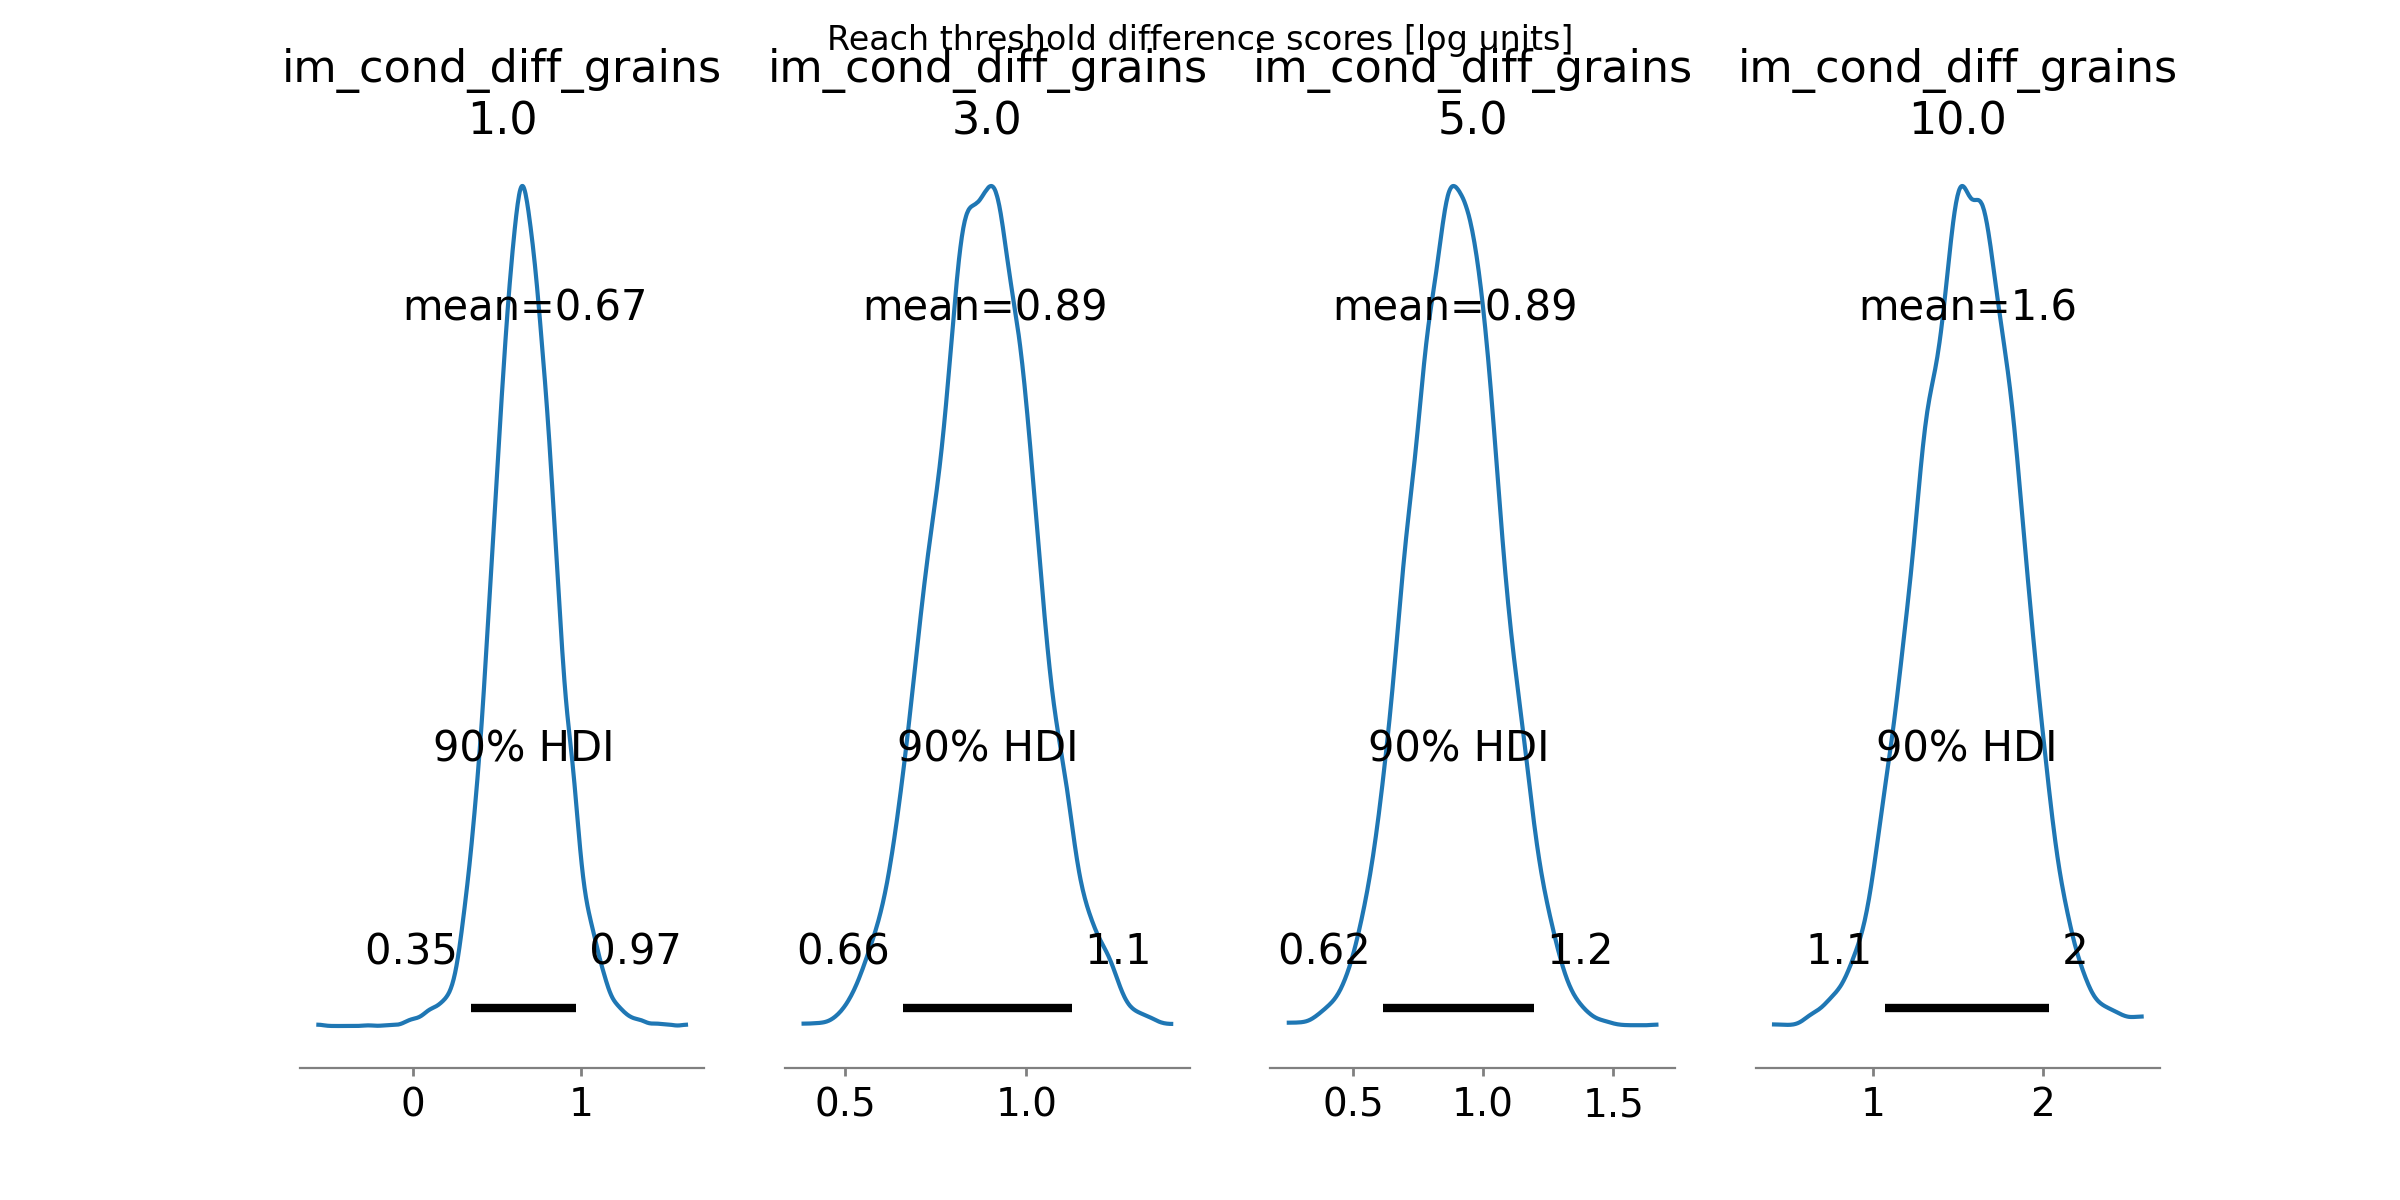

In [30]:
# difference score for each image condition over each grain
axes = az.plot_posterior(
    post,
    var_names=["im_cond_diff_grains"],
    hdi_prob=0.9,
    figsize=(12, 6),
)
fig = axes.flatten()[0].get_figure()
fig.suptitle("Reach threshold difference scores [log units]")
plt.show()

Now compute the mean difference score over grains:

In [31]:
post["im_cond_diff"] = post["im_cond_diff_grains"].mean(dim="grain")
az.summary(post, var_names=["im_cond_diff"], hdi_prob=0.90)

mean     sd  hdi_5%  hdi_95%  mcse_mean  mcse_sd  ess_bulk  \
im_cond_diff   1.0  0.107   0.828    1.176      0.001    0.001    8625.0   

              ess_tail  r_hat  
im_cond_diff    7414.0    1.0

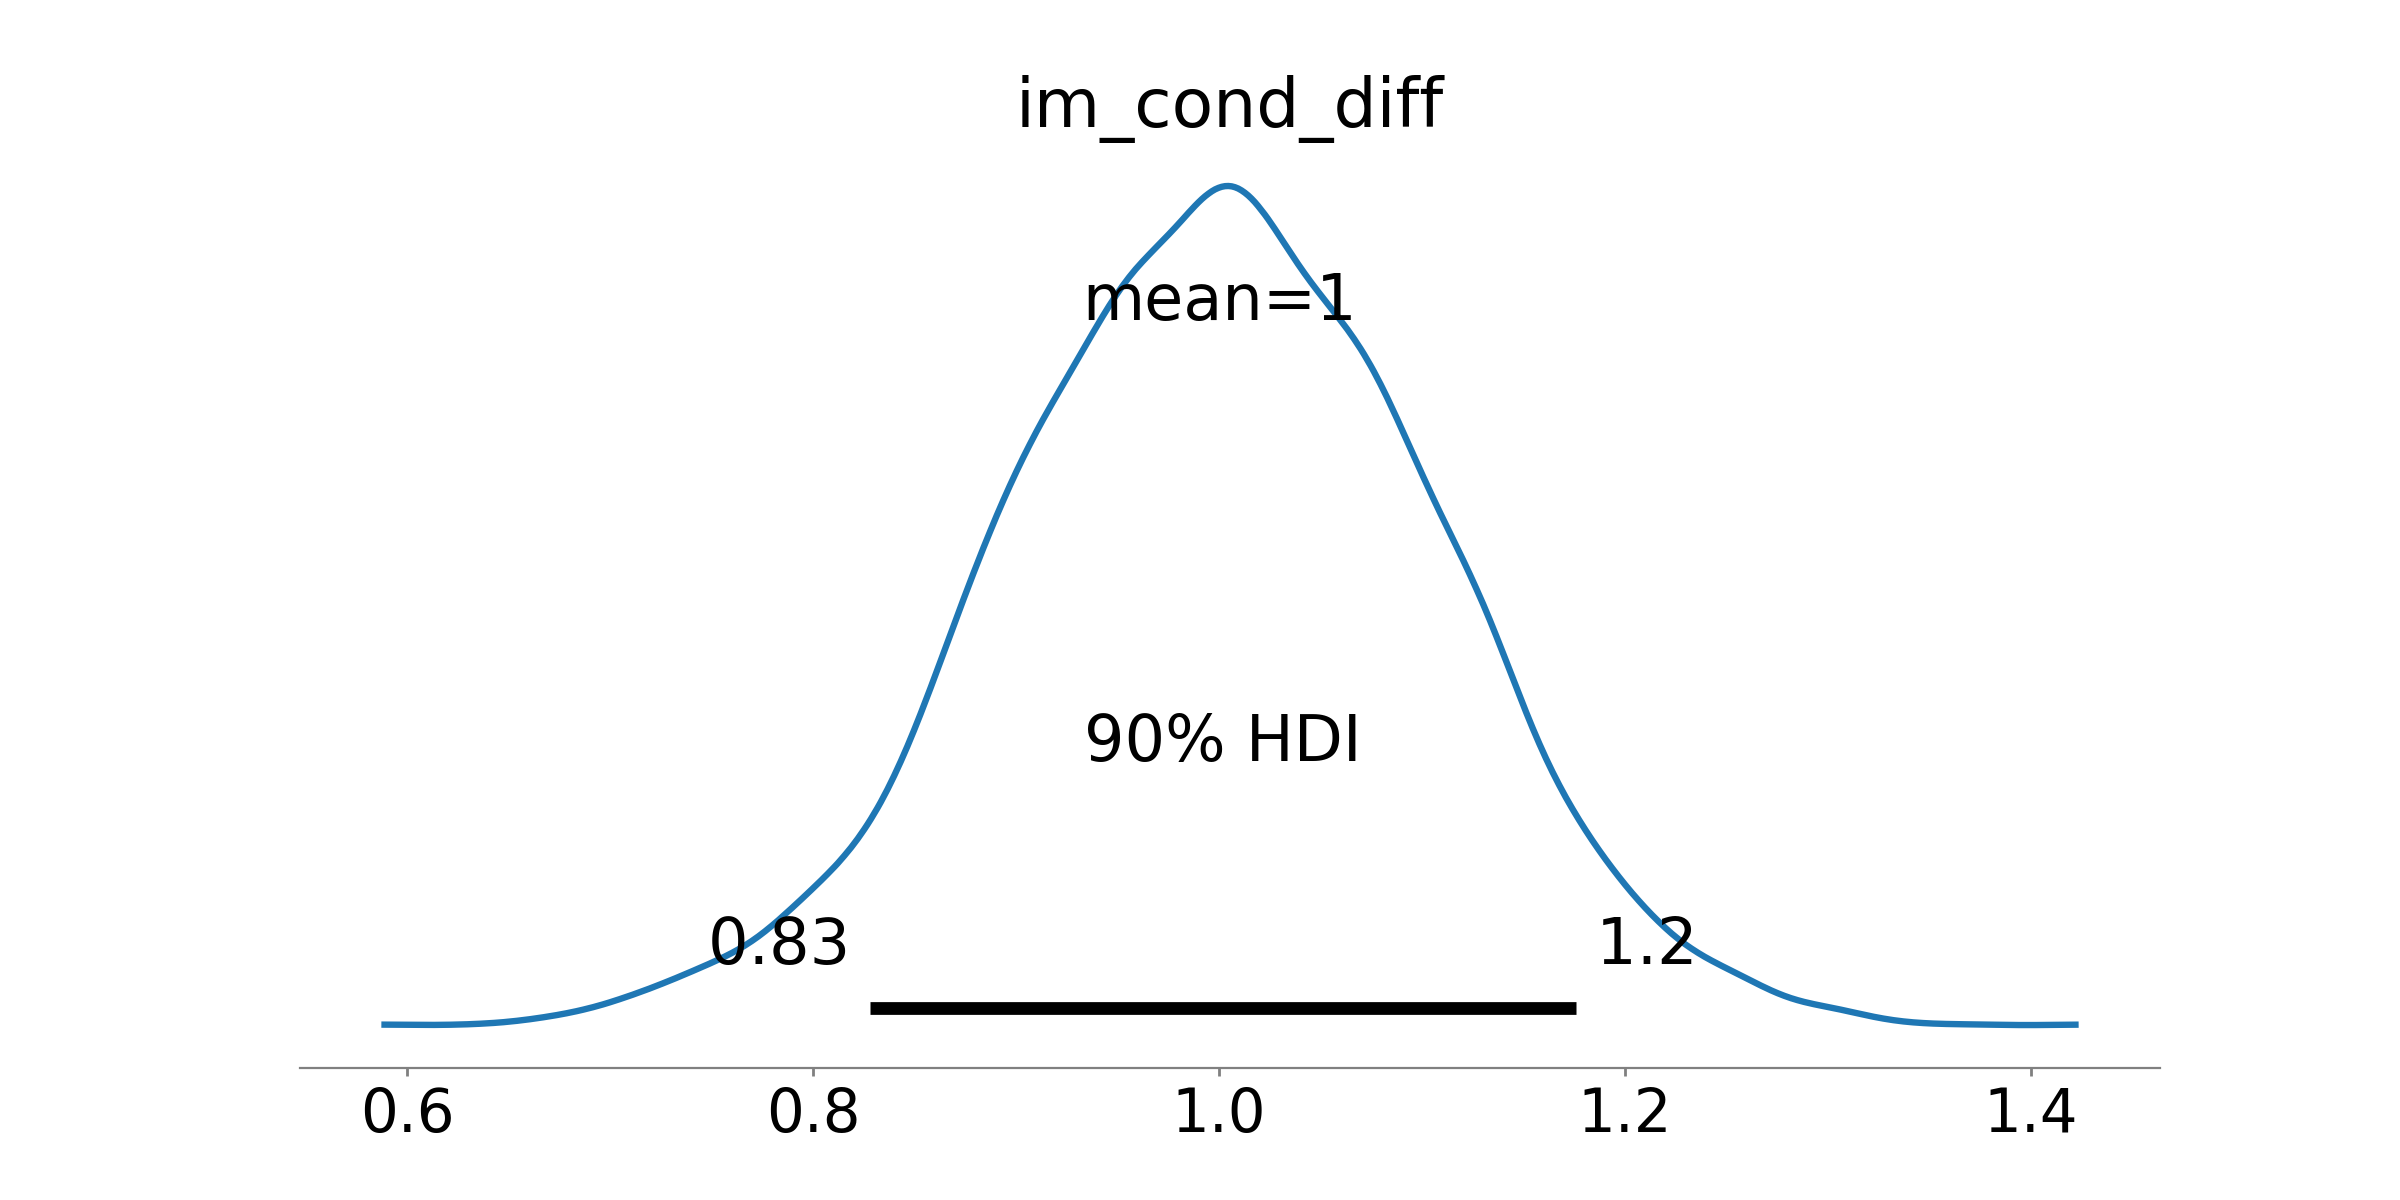

In [32]:
axes = az.plot_posterior(
    post,
    var_names=["im_cond_diff"],
    hdi_prob=0.9,
    figsize=(12, 6),
)
plt.show()

In other words: averaging over grains and participants, reach thresholds
for textures are on average 0.6 reach units higher than scenes (90% HDI
0.496 – 0.705).

# Multilevel model including image-level effects

In [33]:
rng_key = random.PRNGKey(42)
m3 = ParticipantsAllConditionsAndImages(
    data=grouped_image_df,
    rng_key=rng_key,
    intensity_variable_name="reach",
    experiment_conditions=["image_condition", "grain"],
    group_variables=["participant", "image_name"],
    use_reparam=True,
)

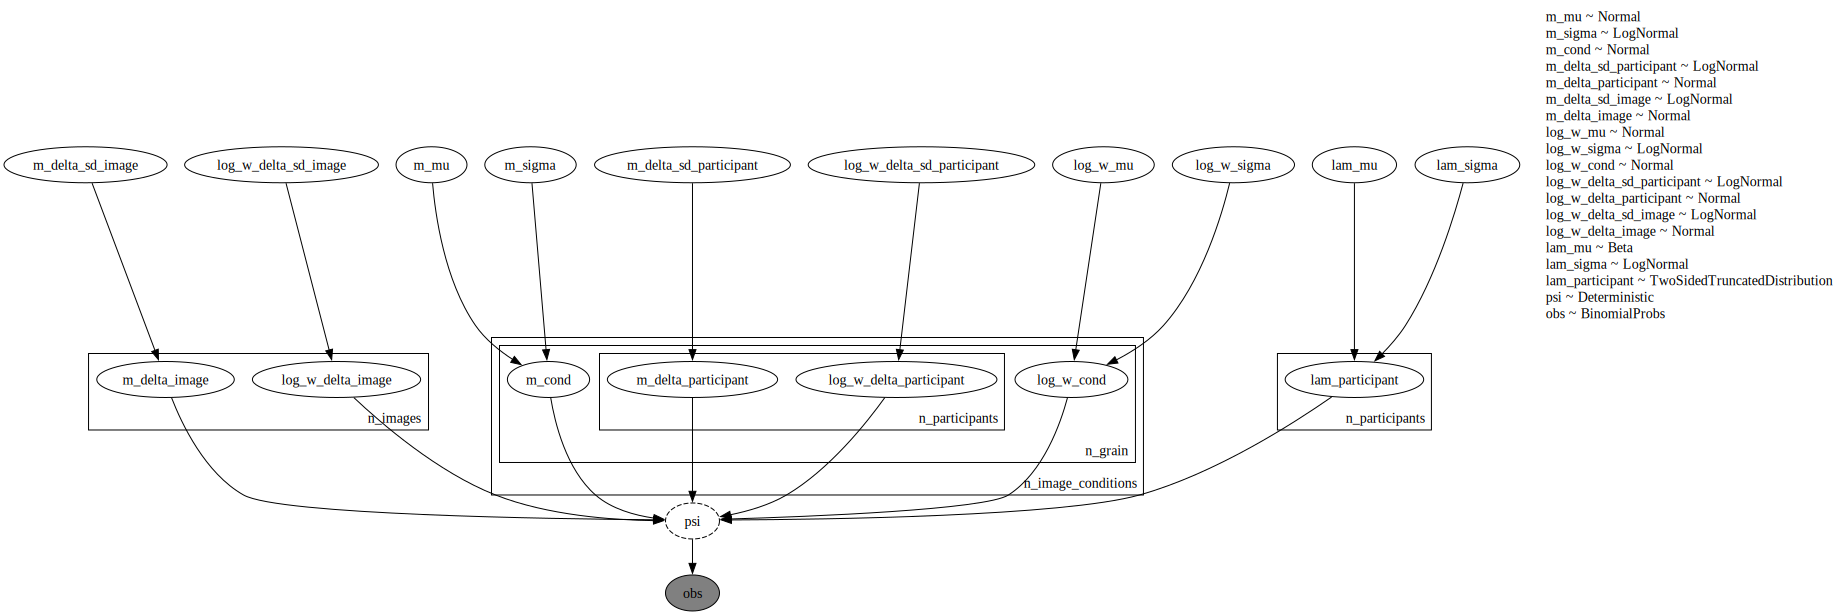

In [34]:
# render the model! (requires graphviz on system level)
# note to simplify we will exclude the reparam:
m3_tmp = ParticipantsAllConditionsAndImages(
    data=grouped_image_df,
    rng_key=rng_key,
    intensity_variable_name="reach",
    experiment_conditions=["image_condition", "grain"],
    group_variables=["participant", "image_name"],
    use_reparam=False,
)
m3_graph = numpyro.render_model(
    m3_tmp.model,
    render_distributions=True,
    render_params=True,
)
m3_graph.render(top_dir / "figures" / "m3_graph")
m3_graph

## Sample the model and check the overall output

Sample from this model for all data:

In [35]:
m3.sample(num_warmup=4000, num_samples=2000)

Compiling.. :   0%|          | 0/6000 [00:00<?, ?it/s]






Running chain 0:   0%|          | 0/6000 [00:11<?, ?it/s]


Running chain 0:   5%|▌         | 300/6000 [00:16<01:29, 63.91it/s]




Running chain 0:  15%|█▌        | 900/6000 [00:19<00:39, 129.17it/s]


Running chain 0:  20%|██        | 1200/6000 [00:21<00:34, 140.92it/s]



Running chain 0:  25%|██▌       | 1500/6000 [00:23<00:29, 152.48it/s]


Running chain 0:  30%|███       | 1800/6000 [00:25<00:26, 156.32it/s]


Running chain 0:  35%|███▌      | 2100/6000 [00:26<00:23, 164.54it/s]


Running chain 0:  40%|████      | 2400/6000 [00:28<00:20, 173.63it/s]


Running chain 0:  45%|████▌     | 2700/6000 [00:29<00:18, 182.27it/s]


Running chain 0:  50%|█████     | 3000/6000 [00:31<00:15, 191.70it/s]


Running chain 0:  55%|█████▌    | 3300/6000 [00:32<00:13, 198.84it/s]

Running chain 0:  60%|██████    | 3600/6000 [00:33<00:11, 207.80it/s]


Running chain 0:  65%|██████▌   | 3900/6000 [00:34<00:09, 215.39it/s]


Running chain 0:

In [36]:
m3.mcmc.print_summary(0.90)


                                               mean       std    median      5.0%     95.0%     n_eff     r_hat
                                   lam_mu      0.07      0.07      0.05      0.00      0.17  10826.48      1.00
                       lam_participant[0]      0.02      0.00      0.02      0.02      0.03  11217.99      1.00
                       lam_participant[1]      0.01      0.00      0.01      0.01      0.01  11730.70      1.00
                                lam_sigma      0.55      0.78      0.32      0.01      1.26   8073.18      1.00
               log_w_cond_decentered[0,0]     -0.42      0.92     -0.43     -1.92      1.08  12353.00      1.00
               log_w_cond_decentered[0,1]      0.01      0.82      0.02     -1.43      1.25  11559.71      1.00
               log_w_cond_decentered[0,2]      0.10      0.89      0.10     -1.37      1.54  12312.76      1.00
               log_w_cond_decentered[0,3]     -0.03      0.83     -0.02     -1.37      1.34  11520.85  

## Plot psychometric functions

/Users/tsawallis/HESSENBOX-DA/tsawallis/Projects/numpyro_psychometric_function_tutorial/src/numpyro_models.py:125: UserWarning: Sample's batch dimension size 8000 is different from the provided 50 num_samples argument. Defaulting to 8000.
/Users/tsawallis/HESSENBOX-DA/tsawallis/Projects/numpyro_psychometric_function_tutorial/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 8 x 5 in image.
/Users/tsawallis/HESSENBOX-DA/tsawallis/Projects/numpyro_psychometric_function_tutorial/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /Users/tsawallis/HESSENBOX-DA/tsawallis/Projects/numpyro_psychometric_function_tutorial/figures/m3_psychometric_functions.pdf


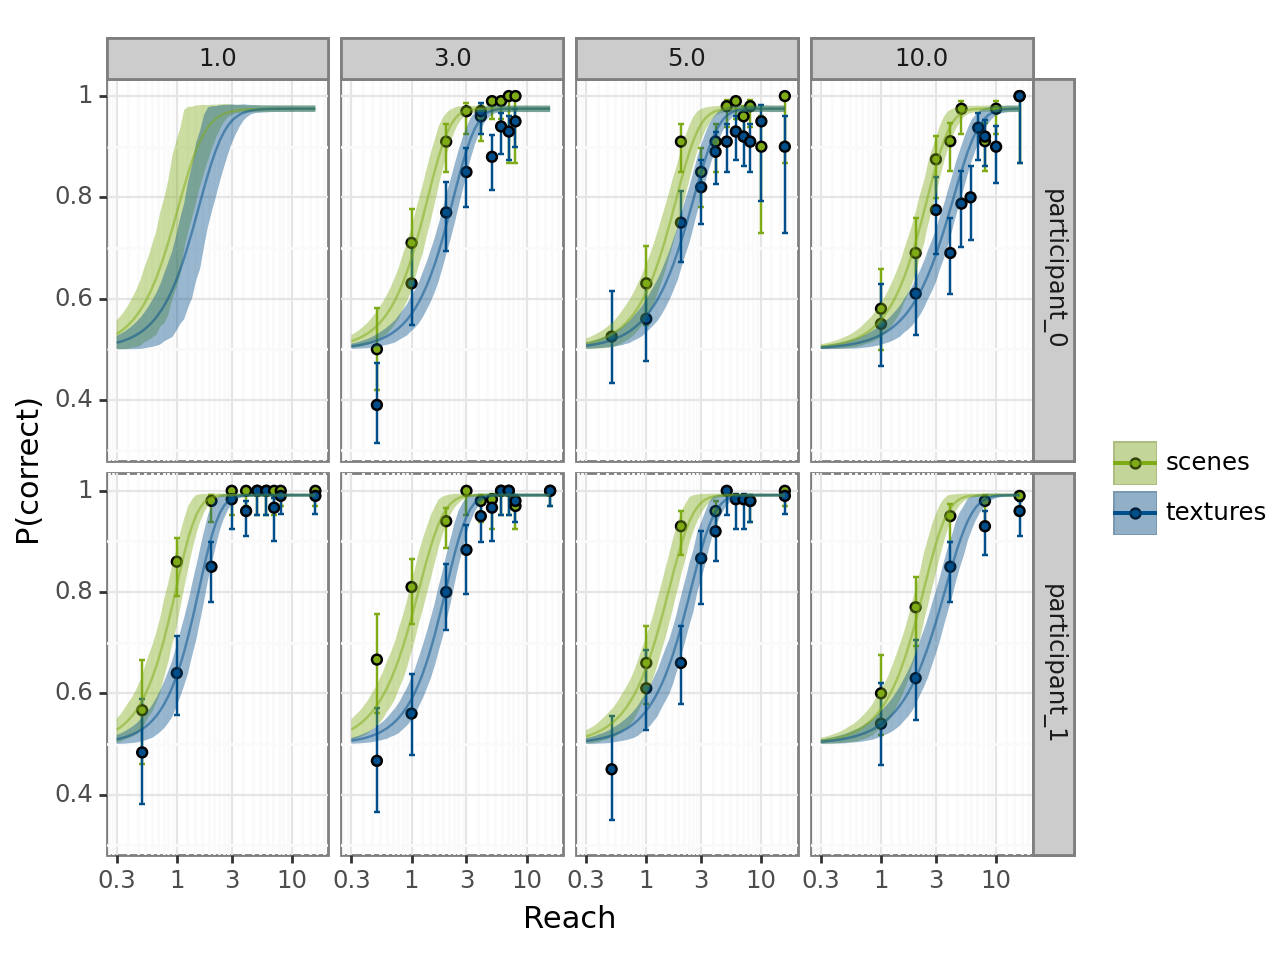

In [37]:
x = np.logspace(np.log10(0.3), np.log10(16), 51)
pred_df = expand_grid(
    {
        "reach": x,
        "participant": grouped_df["participant"].unique(),
        "grain": grouped_df["grain"].unique(),
        "image_condition": grouped_df["image_condition"].unique(),
    }
)
pred_df["image_name"] = "None"
pred_df, _ = PsychometricFunctionWrapper.create_grouping_ids(
    pred_df,
    experiment_conditions=["image_condition", "grain"],
    group_variables=["participant", "image_name"],
)

posterior_samples = m3.predict(
    data=pred_df,
    prior=False,
    sample_obs=False,
    model_kwargs={"include_participant_re": True, "include_image_re": False},
)
post_pred_mean = posterior_samples["psi"].mean(axis=0)
post_pred_hpdi = hpdi(posterior_samples["psi"], 0.9)
pred_df["post_mean"] = post_pred_mean
pred_df["post_lower"] = post_pred_hpdi[0]
pred_df["post_upper"] = post_pred_hpdi[1]

plt_5 = plt_1
plt_5 = (
    plt_5
    + pn.geom_ribbon(
        data=pred_df,
        mapping=pn.aes(
            ymin="post_lower",
            ymax="post_upper",
        ),
        color=None,
        outline_type="full",
        alpha=0.4,
    )
    + pn.geom_line(
        data=pred_df,
        mapping=pn.aes(y="post_mean"),
        alpha=0.5,
    )
)

plt_5.save(
    top_dir / "figures" / "m3_psychometric_functions.pdf",
    width=8,
    height=5,
)
plt_5.draw()

## Plot parameter estimates

### Thresholds

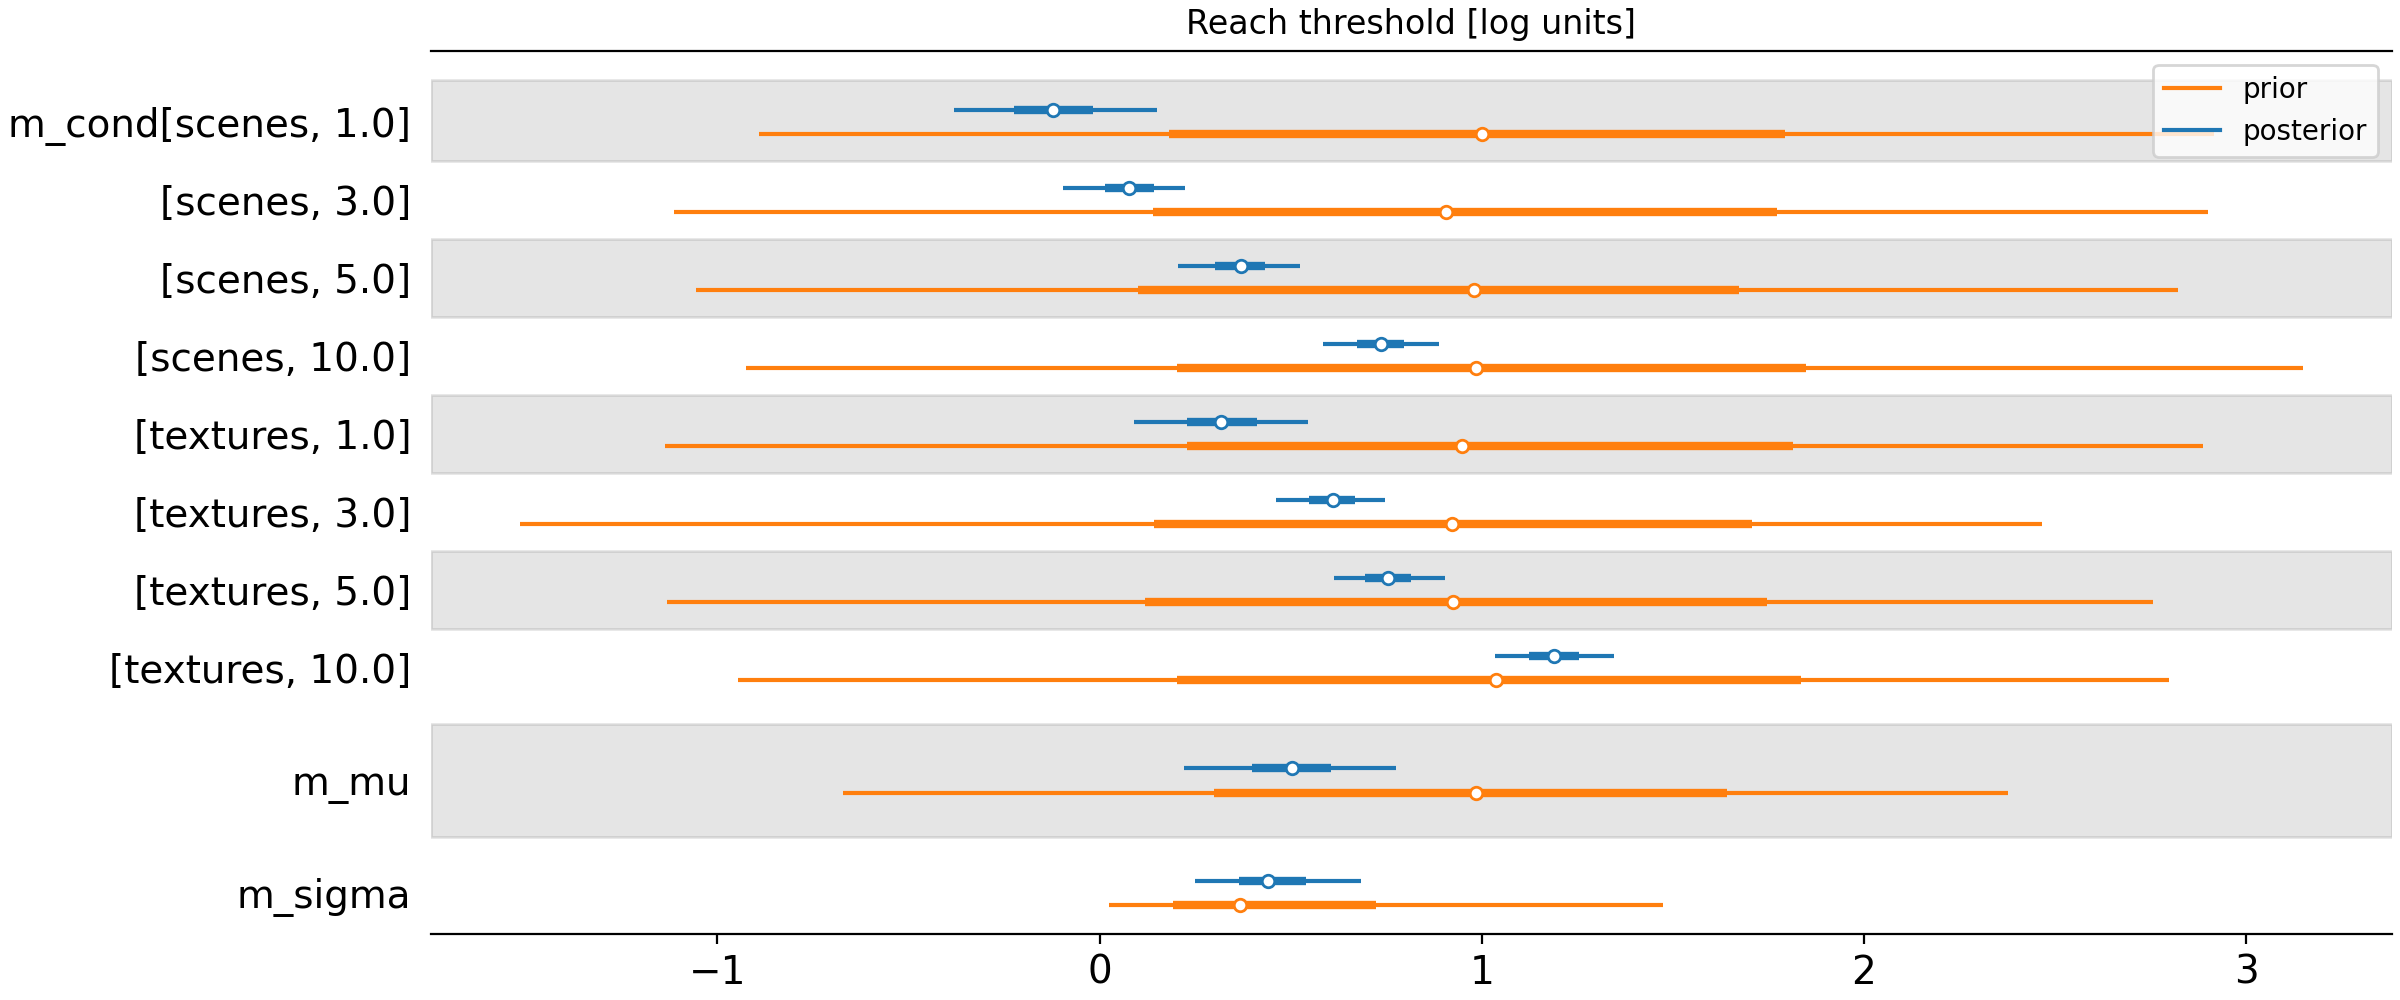

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5), layout="constrained")
ax = az.plot_forest(
    [m3.arviz_data["posterior"], m3.arviz_data["prior"]],
    model_names=["posterior", "prior"],
    kind="forestplot",
    var_names=["m_cond", "m_mu", "m_sigma"],
    # transform=np.exp,
    hdi_prob=0.9,
    combined=True,
    ridgeplot_overlap=1.5,
    ax=ax,
)
ax[0].set_title("Reach threshold [log units]")
plt.show()

We can also look at the image-level offsets:

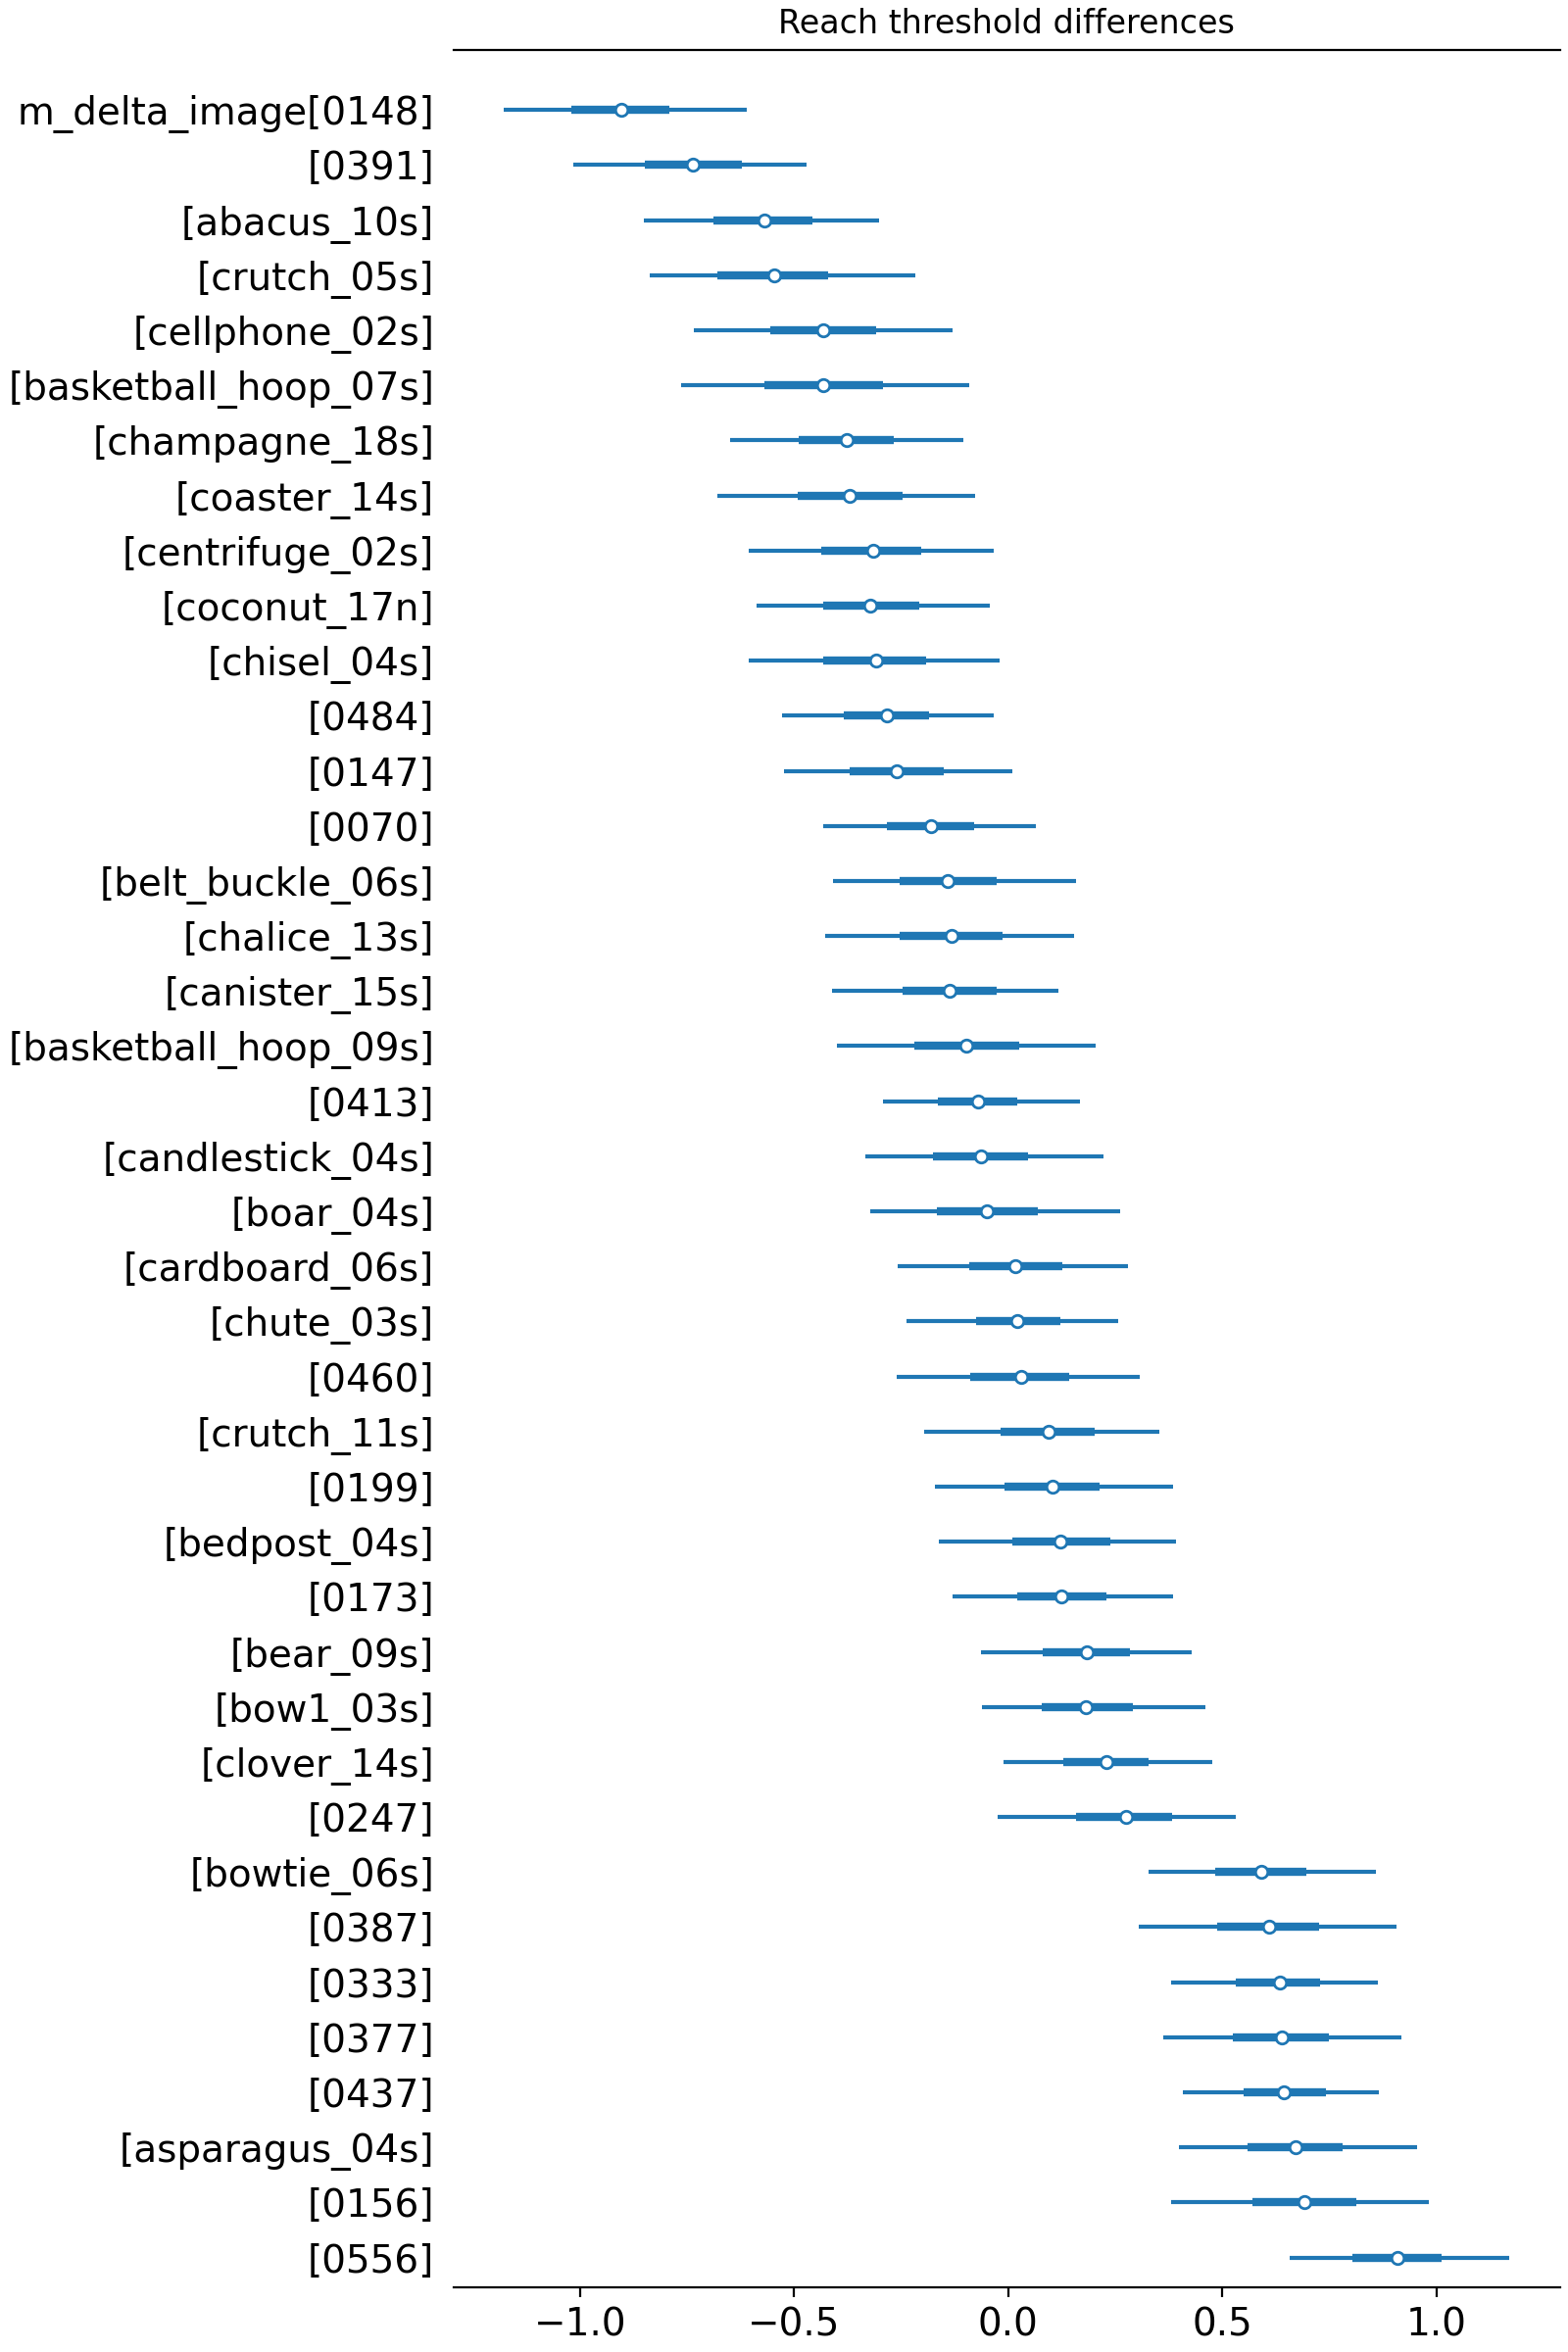

In [39]:
# create a sorted variable:
# https://python.arviz.org/en/stable/user_guide/label_guide.html#example-sorting-the-schools-by-mean
image_means = m3.arviz_data["posterior"]["m_delta_image"].mean(("chain", "draw"))
sorted_images = m3.arviz_data["posterior"]["image_name"].sortby(image_means)

fig, ax = plt.subplots(1, 1, figsize=(8, 12), layout="constrained")
ax = az.plot_forest(
    m3.arviz_data["posterior"],
    kind="forestplot",
    var_names=["m_delta_image"],
    coords={"image_name": sorted_images},
    hdi_prob=0.9,
    combined=True,
    ridgeplot_overlap=1.5,
    ax=ax,
)
ax[0].set_title("Reach threshold differences")
plt.savefig(top_dir / "figures" / "m3_image_offsets.pdf")
plt.show()

### Widths

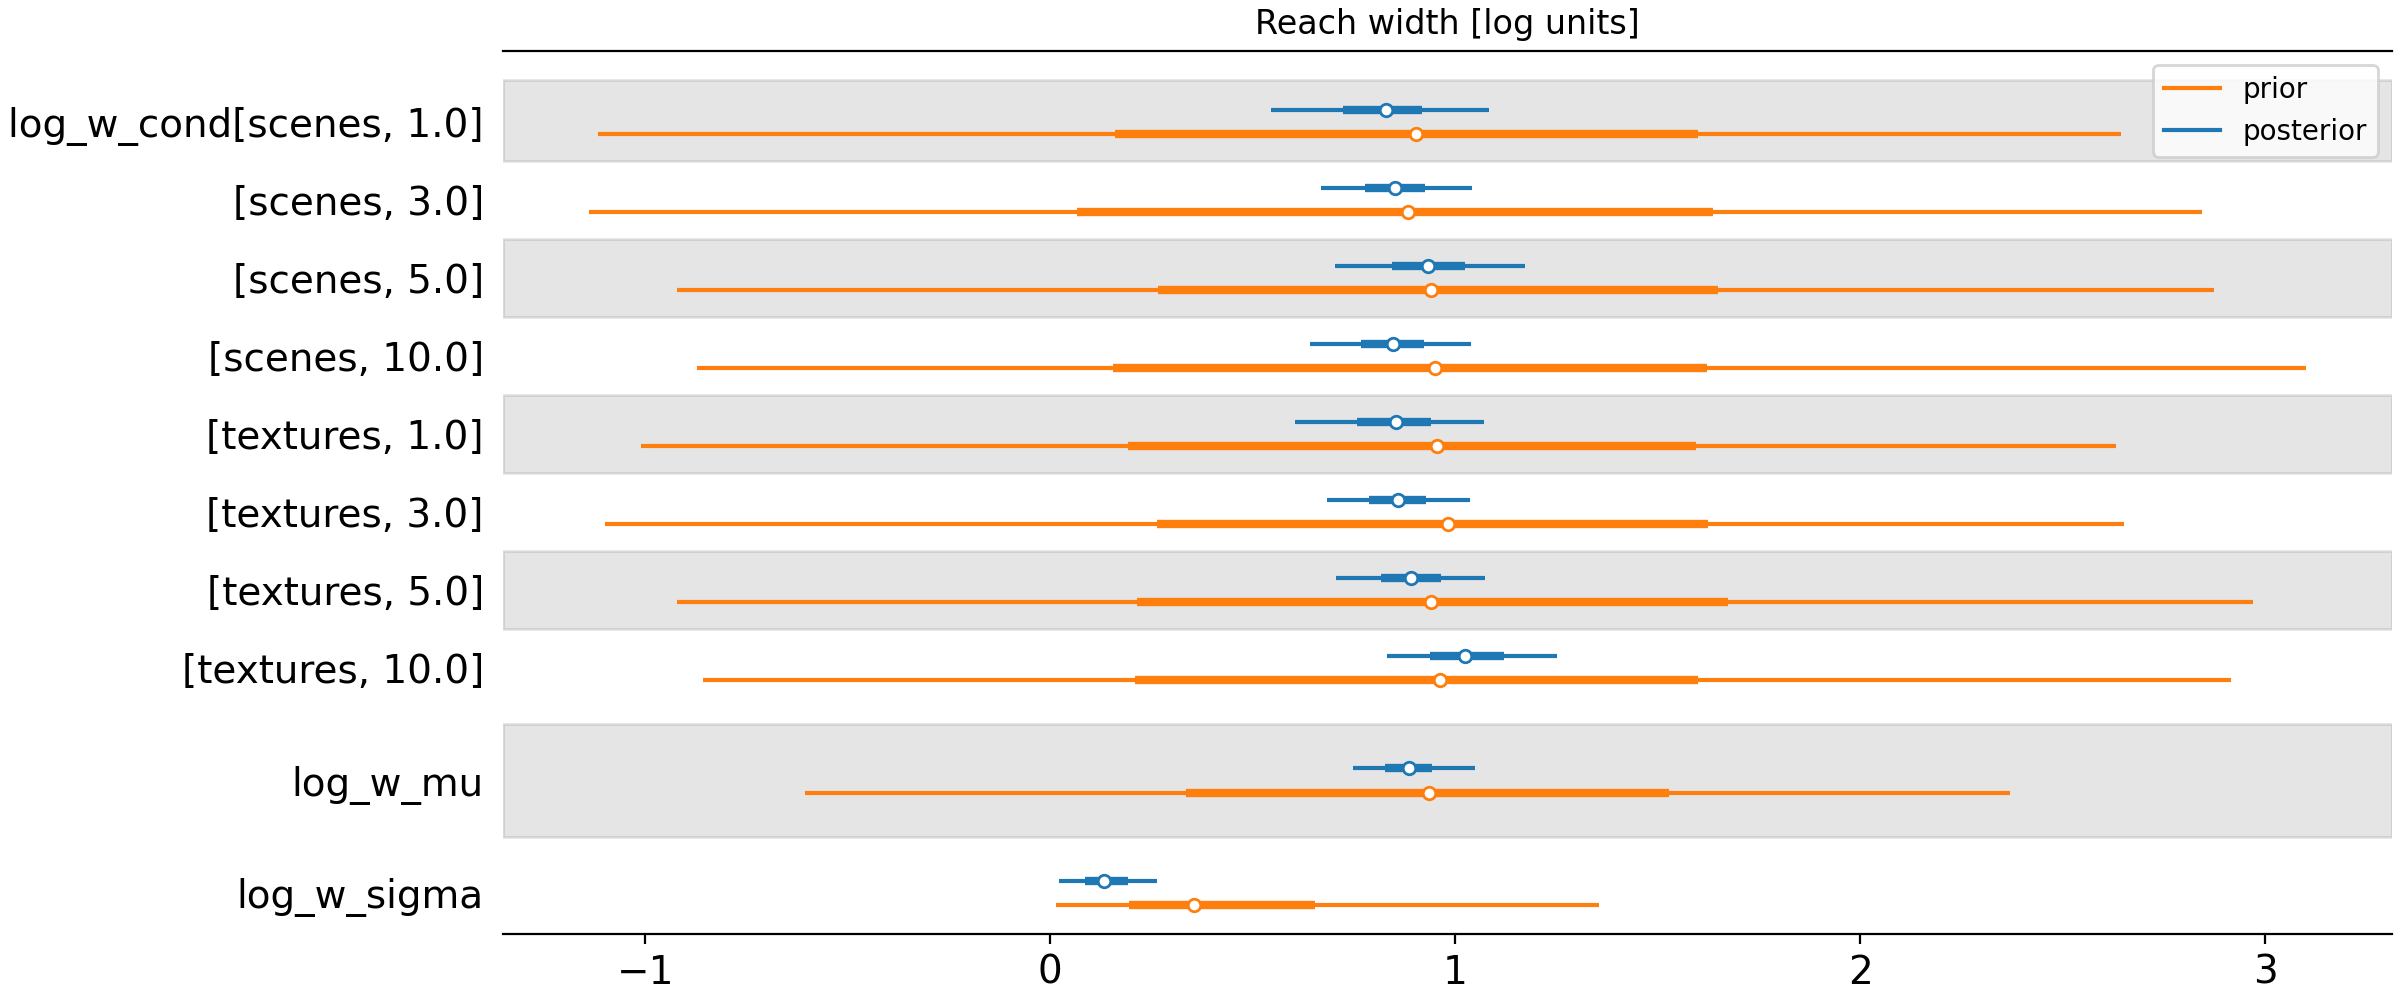

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5), layout="constrained")
ax = az.plot_forest(
    [m2.arviz_data["posterior"], m2.arviz_data["prior"]],
    model_names=["posterior", "prior"],
    kind="forestplot",
    var_names=["log_w_cond", "log_w_mu", "log_w_sigma"],
    # transform=np.exp,
    hdi_prob=0.9,
    combined=True,
    ridgeplot_overlap=1.5,
    ax=ax,
)
ax[0].set_title("Reach width [log units]")
plt.show()

Image-level offsets on width:

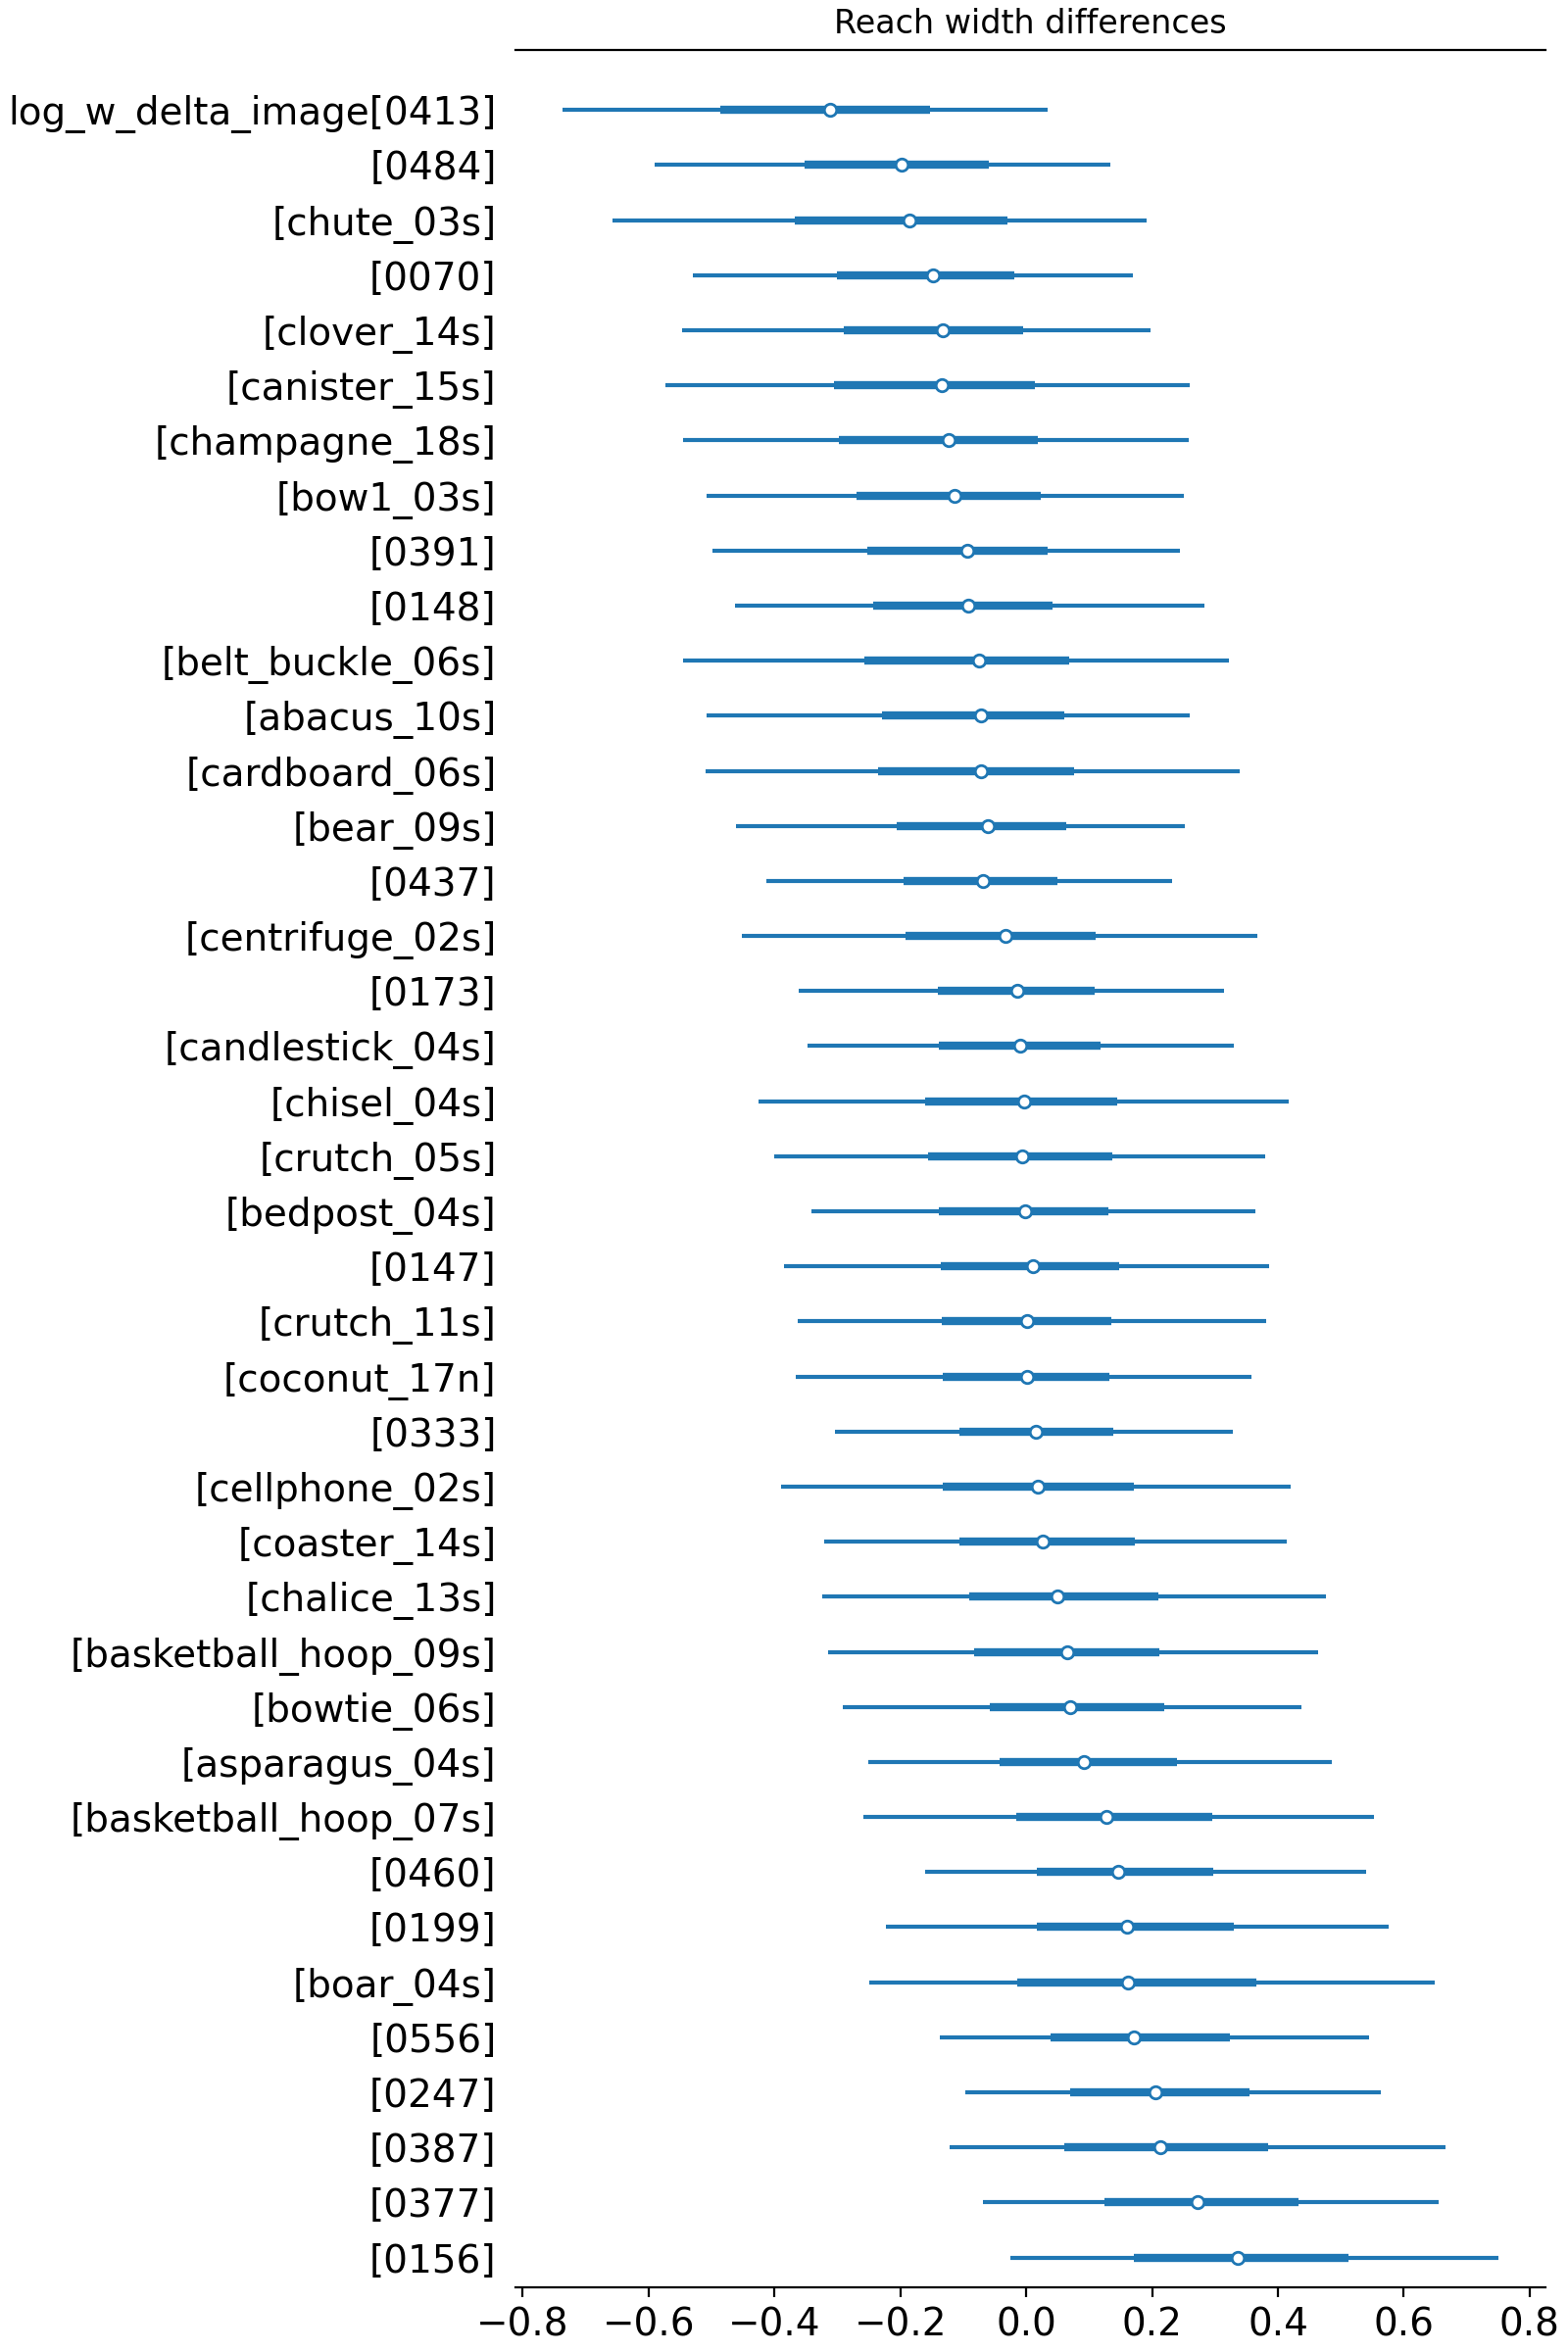

In [41]:
# create a sorted variable:
# https://python.arviz.org/en/stable/user_guide/label_guide.html#example-sorting-the-schools-by-mean
image_means = m3.arviz_data["posterior"]["log_w_delta_image"].mean(("chain", "draw"))
sorted_images = m3.arviz_data["posterior"]["image_name"].sortby(image_means)

fig, ax = plt.subplots(1, 1, figsize=(8, 12), layout="constrained")
ax = az.plot_forest(
    m3.arviz_data["posterior"],
    kind="forestplot",
    var_names=["log_w_delta_image"],
    coords={"image_name": sorted_images},
    hdi_prob=0.9,
    combined=True,
    ridgeplot_overlap=1.5,
    ax=ax,
)
ax[0].set_title("Reach width differences")
plt.show()

## Plot per-image psychometric functions

A new cool thing we can do here is to plot the psychometric functions
for each image. First generate predictions:

In [42]:
x = np.logspace(np.log10(0.3), np.log10(16), 51)
pred_df = expand_grid(
    {
        "reach": x,
        "image_name": grouped_image_df["image_name"].unique(),
        "grain": grouped_image_df["grain"].unique(),
    }
)
pred_df["participant"] = "None"

# merge in correct image_condition codes for each image:
pred_df = pred_df.merge(
    grouped_image_df[["image_name", "image_condition"]].drop_duplicates(),
    on="image_name",
)

pred_df, _ = PsychometricFunctionWrapper.create_grouping_ids(
    pred_df,
    experiment_conditions=["image_condition", "grain"],
    group_variables=["participant", "image_name"],
)

posterior_samples = m3.predict(
    data=pred_df,
    prior=False,
    sample_obs=False,
    model_kwargs={"include_participant_re": False, "include_image_re": True},
)
post_pred_mean = posterior_samples["psi"].mean(axis=0)
post_pred_hpdi = hpdi(posterior_samples["psi"], 0.9)
pred_df["post_mean"] = post_pred_mean
pred_df["post_lower"] = post_pred_hpdi[0]
pred_df["post_upper"] = post_pred_hpdi[1]

/Users/tsawallis/HESSENBOX-DA/tsawallis/Projects/numpyro_psychometric_function_tutorial/src/numpyro_models.py:125: UserWarning: Sample's batch dimension size 8000 is different from the provided 50 num_samples argument. Defaulting to 8000.


Need to re-arrange the data here. Note that this is a bit hacky – we’re
just pooling data over participants rather than taking first the
participant mean, then the average of those.

In [43]:
plot_df = group_bernoulli_trials_into_binomial(
    df,
    stimulus_intensity="reach",
    experiment_conditions=["image_condition", "grain"],
    group_variables=["image_name"],
    bernoulli_outcome_column="correct",
    use_rule_of_succession=True,
)
plot_df = plot_df.dropna()
plot_df

reach image_condition grain           image_name  n_successes  n_trials  \
0       0.5          scenes   1.0                 0387          2.0         3   
1       0.5          scenes   1.0        asparagus_04s          2.0         3   
2       0.5          scenes   1.0  basketball_hoop_07s          3.0         3   
3       0.5          scenes   1.0  basketball_hoop_09s          1.0         3   
4       0.5          scenes   1.0          bedpost_04s          3.0         3   
...     ...             ...   ...                  ...          ...       ...   
1575   16.0        textures  10.0           abacus_10s          6.0         6   
1576   16.0        textures  10.0             bear_09s          6.0         6   
1577   16.0        textures  10.0             boar_04s          6.0         6   
1578   16.0        textures  10.0           clover_14s          6.0         6   
1579   16.0        textures  10.0          coconut_17n          6.0         6   

      proportion_correct  n_failures  beta_lower  beta_mid  beta_upper  \
0               0.666667         1.0    0.248605  0.614272    0.902389   
1               0.666667         1.0    0.248605  0.614272    0.902389   
2               1.000000         0.0    0.472871  0.840896    0.987259   
3               0.333333         2.0    0.097611  0.385728    0.751395   
4               1.000000         0.0    0.472871  0.840896    0.987259   
...                  ...         ...         ...       ...         ...   
1575            1.000000         0.0    0.651836  0.905724    0.992699   
1576            1.000000         0.0    0.651836  0.905724    0.992699   
1577            1.000000         0.0    0.651836  0.905724    0.992699   
1578            1.000000         0.0    0.651836  0.905724    0.992699   
1579            1.000000         0.0    0.651836  0.905724    0.992699   

       plot_lo   plot_hi  
0     0.248605  0.902389  
1     0.248605  0.902389  
2     0.472871  1.000000  
3     0.097611  0.751395  
4     0.472871  1.000000  
...        ...       ...  
1575  0.651836  1.000000  
1576  0.651836  1.000000  
1577  0.651836  1.000000  
1578  0.651836  1.000000  
1579  0.651836  1.000000  

[1580 rows x 13 columns]

Now plot:

/Users/tsawallis/HESSENBOX-DA/tsawallis/Projects/numpyro_psychometric_function_tutorial/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 25 x 8 in image.
/Users/tsawallis/HESSENBOX-DA/tsawallis/Projects/numpyro_psychometric_function_tutorial/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /Users/tsawallis/HESSENBOX-DA/tsawallis/Projects/numpyro_psychometric_function_tutorial/figures/m3_psychometric_functions_by_image_wide.pdf


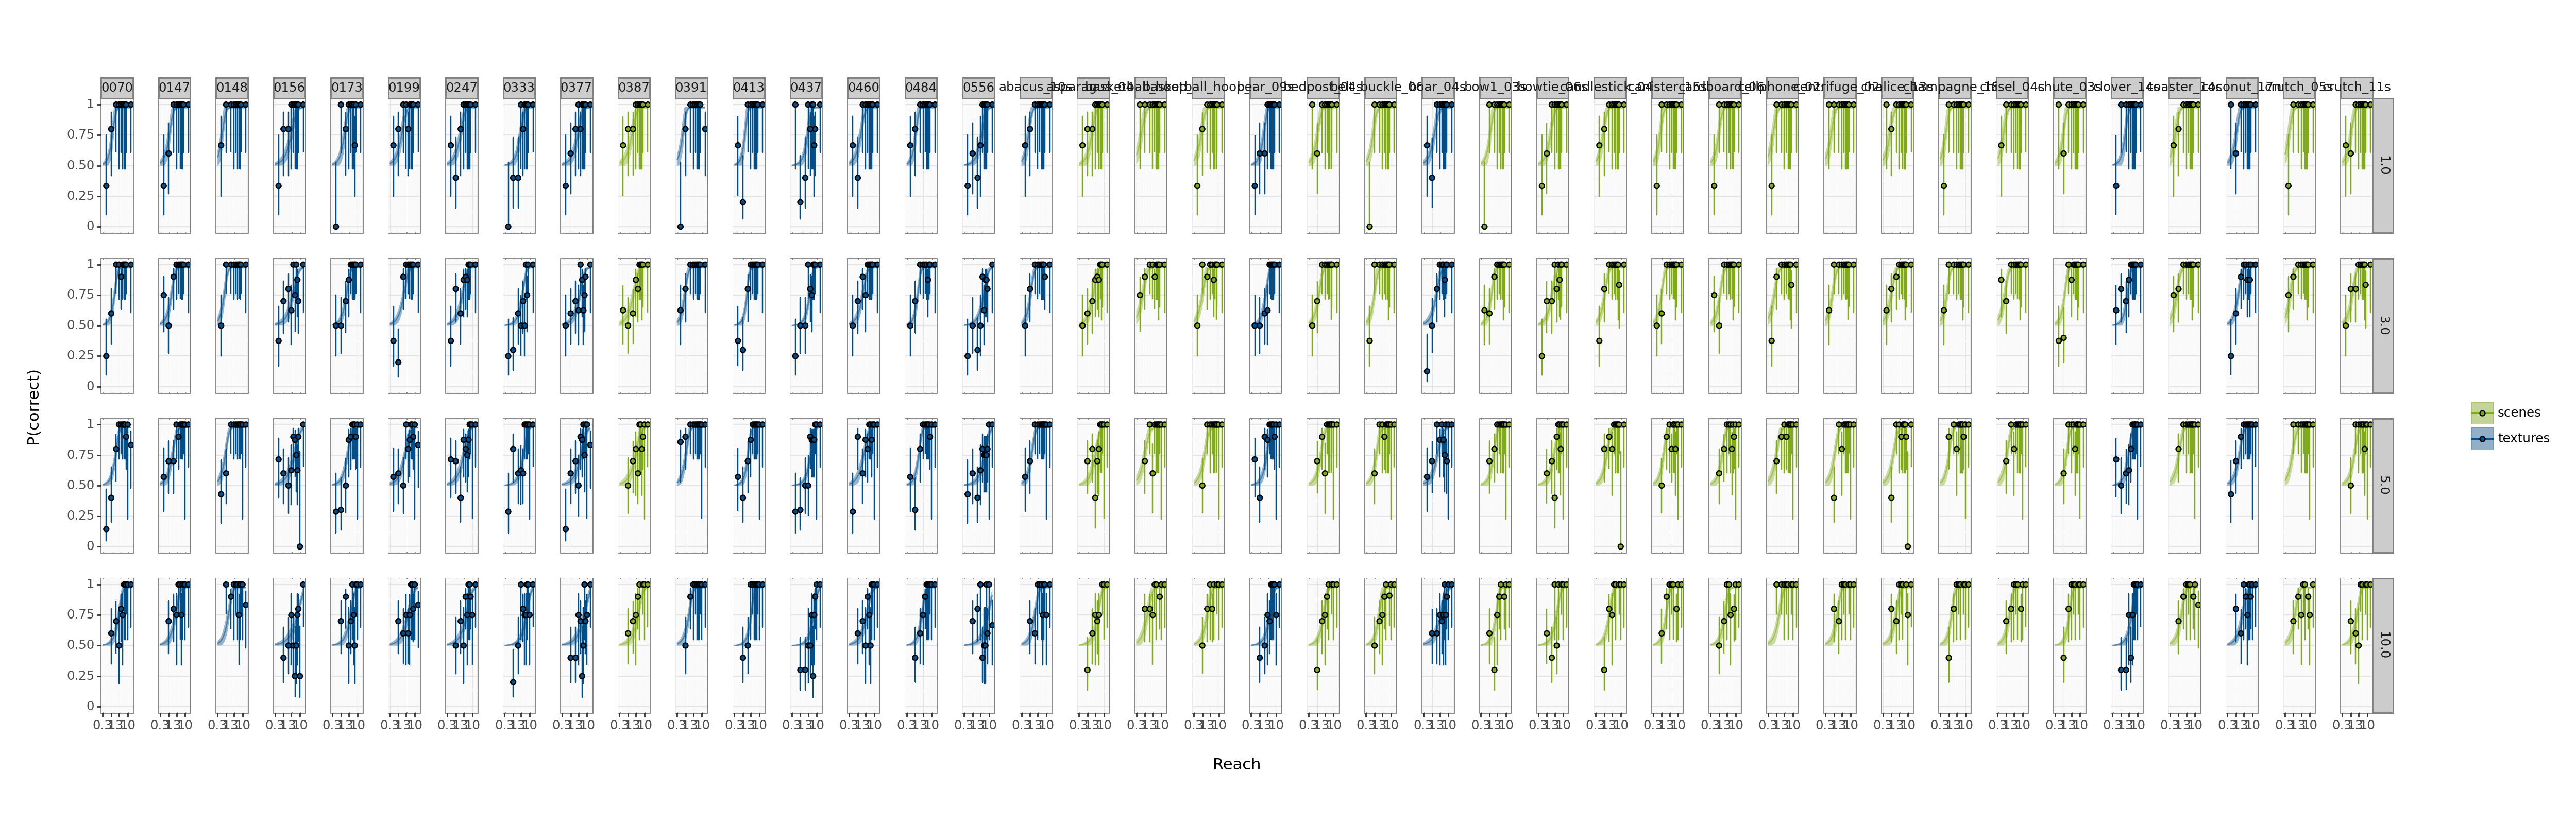

In [44]:
plt_6 = (
    pn.ggplot(
        data=plot_df,
        mapping=pn.aes(x="reach", color="image_condition", fill="image_condition"),
    )
    + pn.facet_grid("grain ~ image_name")
    + pn.geom_ribbon(
        data=pred_df,
        mapping=pn.aes(
            ymin="post_lower",
            ymax="post_upper",
        ),
        color=None,
        outline_type="full",
        alpha=0.4,
    )
    + pn.geom_line(
        data=pred_df,
        mapping=pn.aes(y="post_mean"),
        alpha=0.5,
    )
    + pn.geom_errorbar(mapping=pn.aes(ymin="plot_lo", ymax="plot_hi"), width=0.0)
    + pn.geom_point(mapping=pn.aes(y="proportion_correct"), color="black")
    + pn.scale_x_log10()
    + pn.scale_color_manual(plot_colors)
    + pn.scale_fill_manual(plot_colors)
    + pn.labs(x="Reach", y="P(correct)", color="", fill="")
    + pn.theme_bw()
    + pn.theme(figure_size=(25, 8))
)

plt_6.save(top_dir / "figures" / "m3_psychometric_functions_by_image_wide.pdf")
plt_6.draw()

# Model comparison

Let’s do a model comparison, estimating the expected log posterior
density (ELPD) between the image and the no-image model.

In [45]:
comp_df = az.compare({"no_image_model": m2.arviz_data, "image_model": m3.arviz_data})
comp_df

/Users/tsawallis/HESSENBOX-DA/tsawallis/Projects/numpyro_psychometric_function_tutorial/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
/Users/tsawallis/HESSENBOX-DA/tsawallis/Projects/numpyro_psychometric_function_tutorial/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
/Users/tsawallis/HESSENBOX-DA/tsawallis/Projects/numpyro_psychometric_function_tutorial/.venv/lib/python3.11/site-pa

rank     elpd_loo      p_loo   elpd_diff    weight         se  \
image_model        0 -1701.714002  81.544601    0.000000  0.969933  44.876913   
no_image_model     1 -1912.457616  29.632378  210.743614  0.030067  49.895220   

                      dse  warning scale  
image_model      0.000000     True   log  
no_image_model  23.233387    False   log

First, notice that we get a few warnings here for the image model. This
basically indicates that we don’t really have enough data to reliably
estimate the leave-one-out ELPD.

That aside, notice that here the model including image effects is
strongly preferred, with a difference in ELPD of about 210 (+/- 23.2).
This indicates strong support for the model containing image effects
over a model that treats images the same and only considers variance
over people. See McElreath, Chapter 7, for more.

Arviz also makes a plot:

/Users/tsawallis/HESSENBOX-DA/tsawallis/Projects/numpyro_psychometric_function_tutorial/.venv/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/compareplot.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


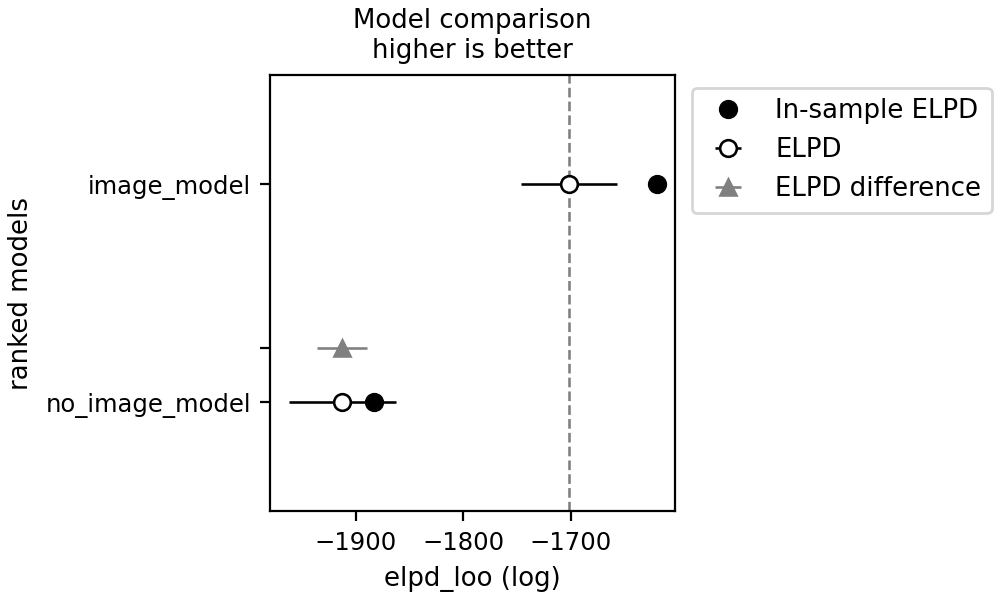

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3), layout="constrained")
ax = az.plot_compare(comp_df, ax=ax, show=True, insample_dev=True)
fig.savefig(top_dir / "figures" / "model_comparison.pdf")
plt.show()